# Predicting the 2024 UEFA Euro Using Poisson Distribution

Football predictions have always been a fascinating topic for data scientists and enthusiasts alike. In this project, we leverage the power of the Poisson distribution to forecast the outcomes of the 2024 UEFA European Championship. This method is particularly well-suited for predicting football scores due to the nature of the game, where goals are relatively rare events.

In [1]:
#intalling the necesary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.colors as mcolors
import warnings
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

# Data Collection
The first step in our analysis involved gathering historical match data. The dataset sourced from Kaggle contains the results of international football matches starting from the very first official match in 1872 up to 2024.

In [2]:
#Reading the 
df = pd.read_csv('results.csv',sep=',',)
#Dropping matches without final result
df=df[~df['home_score'].isna()]

In [3]:
df

date       home_team  away_team  home_score  away_score  \
0      1872-11-30        Scotland    England         0.0         0.0   
1      1873-03-08         England   Scotland         4.0         2.0   
2      1874-03-07        Scotland    England         2.0         1.0   
3      1875-03-06         England   Scotland         2.0         2.0   
4      1876-03-04        Scotland    England         3.0         0.0   
...           ...             ...        ...         ...         ...   
47335  2024-06-25           Chile  Argentina         0.0         1.0   
47336  2024-06-26        Slovakia    Romania         1.0         1.0   
47337  2024-06-26         Ukraine    Belgium         0.0         0.0   
47338  2024-06-26         Georgia   Portugal         2.0         0.0   
47339  2024-06-26  Czech Republic     Turkey         1.0         2.0   

         tournament             city        country  neutral  
0          Friendly          Glasgow       Scotland    False  
1          Friendly           London        England    False  
2          Friendly          Glasgow       Scotland    False  
3          Friendly           London        England    False  
4          Friendly          Glasgow       Scotland    False  
...             ...              ...            ...      ...  
47335  Copa América  East Rutherford  United States     True  
47336     UEFA Euro        Frankfurt        Germany     True  
47337     UEFA Euro        Stuttgart        Germany     True  
47338     UEFA Euro    Gelsenkirchen        Germany     True  
47339     UEFA Euro          Hamburg        Germany     True  

[47340 rows x 9 columns]

# ELO Ranking System

The Elo ranking system is a method for calculating the relative skill levels of teams. It is useful for ranking teams based on their performance in previous matches. The Elo rating is dynamic, meaning it changes based on the results of matches, rewarding teams for wins and penalizing them for losses, while also considering the strength of the opponents.

To create our dataset, we need to define some parameters, such as the importance of each tournament in the points exchanged by the Elo ranking system.

In [4]:
#Auxiliary funtions for update the ratings
confederation_tournaments=['AFC Asian Cup','African Cup of Nations','UEFA Euro','Copa América','CONCACAF Championship','Oceania Nations Cup']
confederation_clasification=['UEFA Euro qualification','African Cup of Nations qualification','FC Asian Cup qualification','UEFA Nations League']
def k_value(tournament):
    k=5
    if tournament == 'Friendly':
        k=10
    elif tournament in confederation_clasification:
        k=20
    elif tournament == 'FIFA World Cup qualification':
        k=25
    elif tournament in confederation_tournaments:
        k=40
    elif tournament == 'FIFA World Cup':
        k=50
    return k

def expected_result(loc,aw):
    dr=loc-aw
    we=(1/(10**(-dr/400)+1))
    return [np.round(we,3),1-np.round(we,3)]

def actual_result(loc,aw):
    if loc<aw:
        wa=1
        wl=0
    elif loc>aw:
        wa=0
        wl=1
    elif loc==aw:
        wa=0.5
        wl=0.5
    return [wl,wa]

def calculate_elo(elo_l,elo_v,local_goals,away_goals,tournament):

    k=k_value(tournament)
    wl,wv=actual_result(local_goals,away_goals)
    wel,wev=expected_result(elo_l,elo_v)

    elo_ln=elo_l+k*(wl-wel)
    elo_vn=elo_v+k*(wv-wev)

    return elo_ln,elo_vn,wel,wev

In [5]:
#Calculating the elo points for all historical internatinal matches
current_elo={}
for idx,row in df.iterrows():

    local=row['home_team']
    away=row['away_team']
    local_goals=row['home_score']
    away_goals=row['away_score']
    tournament = row['tournament']


    if local not in current_elo.keys():
        current_elo[local]=1300

    if away not in current_elo.keys():
        current_elo[away]=1300

    elo_l=current_elo[local]
    elo_v=current_elo[away]
    elo_ln,elo_vn, wel,wev=calculate_elo(elo_l,elo_v,local_goals,away_goals,tournament)

    current_elo[local]=elo_ln
    current_elo[away]=elo_vn

    df.loc[idx,'Elo_h_after']=elo_ln
    df.loc[idx,'Elo_a_after']=elo_vn
    df.loc[idx,'Elo_h_before']=elo_l
    df.loc[idx,'Elo_a_before']=elo_v
    df.loc[idx,'probH']=wel
    df.loc[idx,'probA']=wev

Once we have processed the historical data of international matches, we can calculate the final Elo points for each team. This gives us the current Elo ranking, which reflects the latest performance levels of the teams.

In [6]:
elos=pd.concat([df[['date','home_team','Elo_h_after']].rename(columns={'home_team':'Team','Elo_h_after':'Elo'}),df[['date','away_team','Elo_a_after']].rename(columns={'away_team':'Team','Elo_a_after':'Elo'})])
elos.sort_values(by='date', ascending=False,inplace=True)
elos.drop_duplicates('Team',inplace=True)
elos.sort_values(by='Elo', ascending=False, inplace=True)
elos.reset_index(drop=True, inplace=True)
elos['position']=elos.index+1

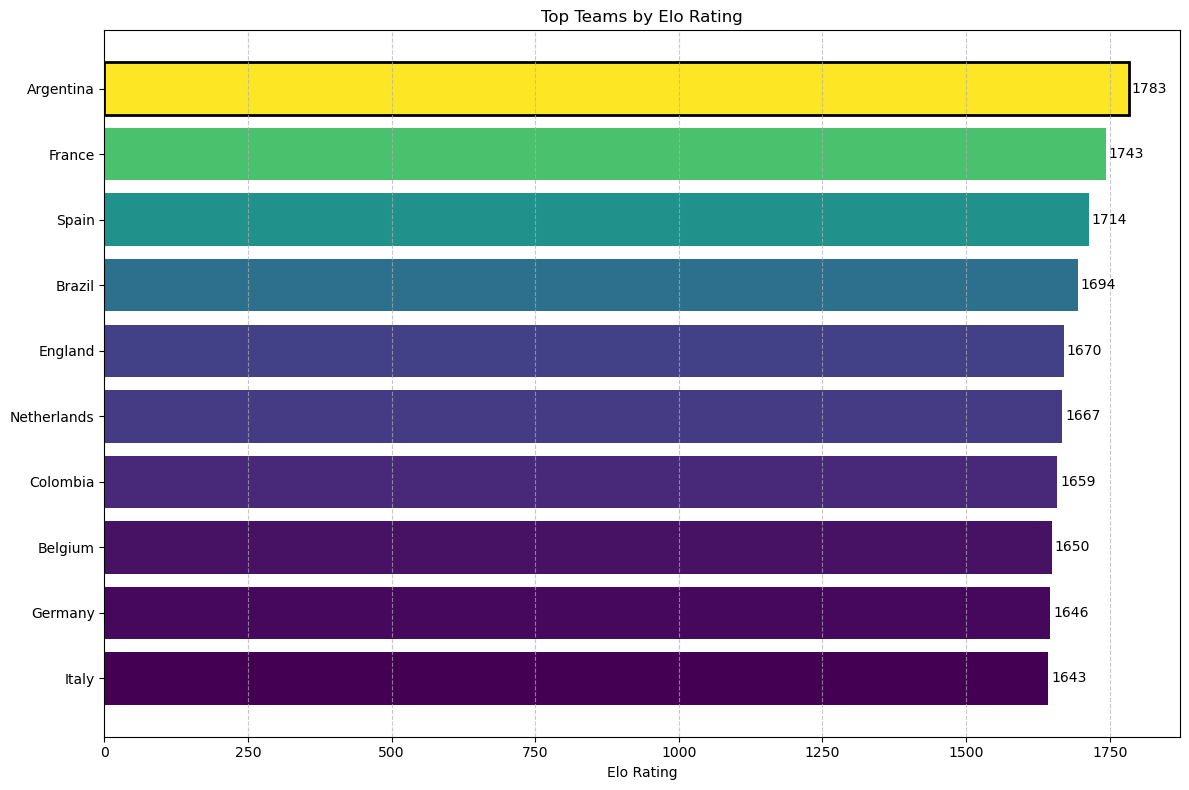

In [7]:
def plot_top_elo(elos, n=10):
    """
    Plots the top n teams by Elo rating in a horizontal bar chart.
    
    Parameters:
    elos (pd.DataFrame): DataFrame containing 'Team' and 'Elo' columns.
    n (int): Number of top teams to display.
    """
    # Sort elos DataFrame by Elo rating in descending order
    elos.sort_values(by='Elo', ascending=False, inplace=True)

    # Select only the top n teams
    top_teams = elos.head(n)

    # Create a color map
    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=min(top_teams['Elo']), vmax=max(top_teams['Elo']))
    colors = cmap(norm(top_teams['Elo']))

    # Plotting
    plt.figure(figsize=(12, 8))
    bars = plt.barh(top_teams['Team'], top_teams['Elo'], color=colors)
    
    # Add text annotations
    for bar in bars:
        plt.text(
            bar.get_width() + 5, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.0f}', 
            ha='left', 
            va='center',
            fontsize=10
        )

    # Highlighting the top team
    bars[0].set_edgecolor('black')
    bars[0].set_linewidth(2)

    # Customizing the plot
    plt.xlabel('Elo Rating')
    plt.title('Top Teams by Elo Rating')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest Elo at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function
plot_top_elo(elos, 10)


We will focus only on the teams participating in the 2024 Euro. Therefore, the ranking would be as follows:

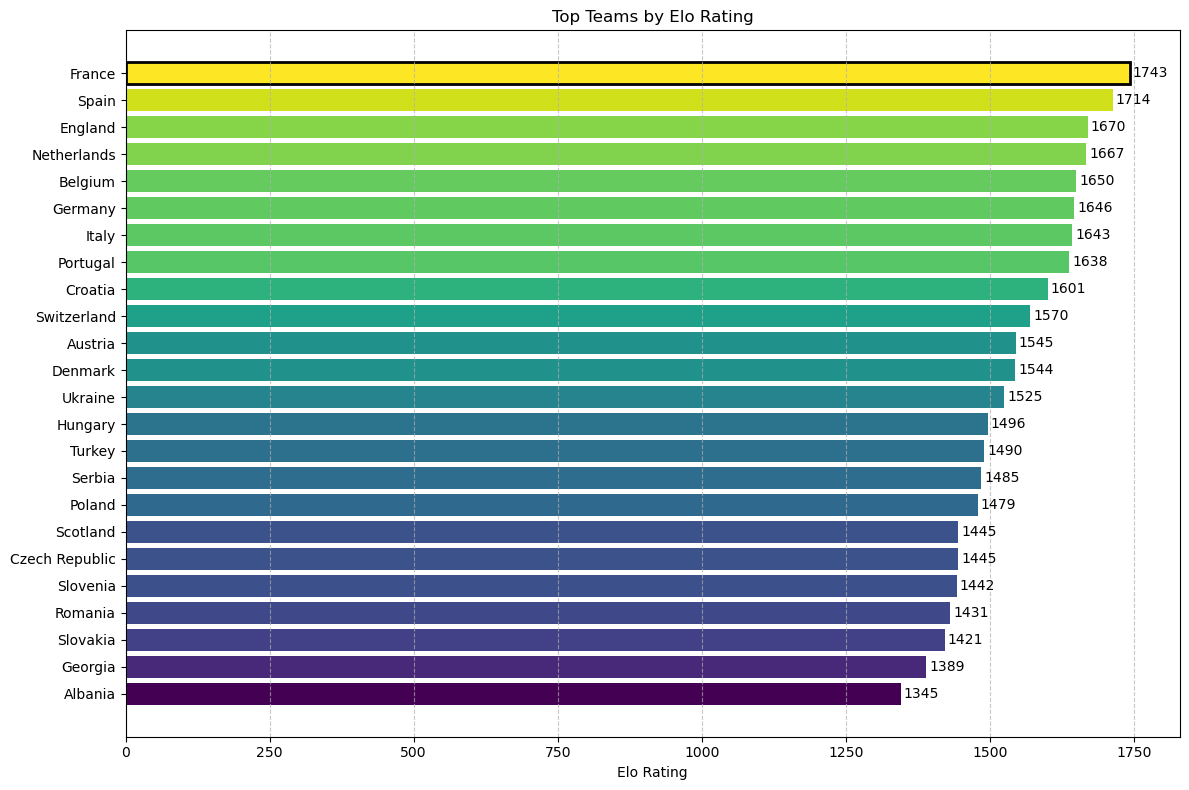

In [8]:
eurocup_teams =[
    "Albania", "Scotland", "Hungary", "Romania",
    "Germany", "Slovakia", "England", "Czech Republic",
    "Austria", "Slovenia", "Italy", "Serbia",
    "Belgium", "Spain", "Netherlands", "Switzerland",
    "Croatia", "France", "Poland", "Turkey",
    "Denmark", "Georgia", "Portugal", "Ukraine"
]

elos_ranking_euro = elos[elos.Team.isin(eurocup_teams)].copy()
plot_top_elo(elos_ranking_euro,24)

Based on this ranking, we can say that France is the favorite to win the Euro, while Albania is the weakest team in the tournament.

One of the problems with international matches is that we don't have the statistics of a league, making it difficult to determine which team has a better attack because it depends on the quality of the opponent. To solve this, and using the same idea as the Elo ranking system above, we can create a ranking for attacking power and defensive power.

In [9]:
elos_ranking_euro

date            Team       Elo  position
1   2024-06-25          France  1742.770         2
2   2024-06-24           Spain  1713.675         3
4   2024-06-25         England  1669.975         5
5   2024-06-25     Netherlands  1667.360         6
7   2024-06-26         Belgium  1649.525         8
8   2024-06-23         Germany  1646.390         9
9   2024-06-24           Italy  1643.220        10
11  2024-06-26        Portugal  1637.725        12
13  2024-06-24         Croatia  1600.850        14
16  2024-06-23     Switzerland  1570.075        17
22  2024-06-25         Austria  1544.710        23
23  2024-06-25         Denmark  1544.270        24
24  2024-06-26         Ukraine  1524.660        25
30  2024-06-23         Hungary  1496.465        31
32  2024-06-26          Turkey  1490.005        33
34  2024-06-25          Serbia  1485.295        35
36  2024-06-25          Poland  1479.350        37
53  2024-06-23        Scotland  1445.070        54
54  2024-06-26  Czech Republic  1444.845        55
56  2024-06-25        Slovenia  1442.345        57
58  2024-06-26         Romania  1431.160        59
64  2024-06-26        Slovakia  1421.345        65
71  2024-06-26         Georgia  1389.450        72
82  2024-06-24         Albania  1345.260        83

In [10]:
def calculate_attdef(Attack_l,Attack_v,Deffend_l,Deffend_v,localGoals,awayGoals, tournament,neutral):
    k=k_value(tournament)
    if neutral==False:
        c=1.27
    else:
        c=1
    ehg=Attack_l*Deffend_v*c
    eag=Attack_v*Deffend_l/c
    Attack_ln=Attack_l+(k/2000)*(localGoals-ehg)
    Attack_vn=Attack_v+(k/2000)*(awayGoals-eag)
    Deffend_ln=Deffend_l+(k/2000)*(awayGoals-eag)
    Deffend_vn=Deffend_v+(k/2000)*(localGoals-ehg)
  
    return Attack_ln,Attack_vn,Deffend_ln,Deffend_vn, ehg, eag

In [11]:
current_att={}
current_def={}
for idx,row in df.iterrows():

    local=row['home_team']
    away=row['away_team']
    local_goals=row['home_score']
    away_goals=row['away_score']
    tournament=row['tournament']
    neutral=row['neutral']

    if local not in current_att.keys():
        current_att[local]=1.3
    if away not in current_att.keys():
        current_att[away]=1.3
    if local not in current_def.keys():
        current_def[local]=1.3
    if away not in current_def.keys():
        current_def[away]=1.3

    att_l=current_att[local]
    att_v=current_att[away]
    def_l=current_def[local]
    def_v=current_def[away]

    att_ln,att_vn, def_ln, def_vn, ehg, eag=calculate_attdef(att_l,att_v,def_l,def_v,local_goals,away_goals, tournament,neutral)

    current_att[local]=att_ln
    current_att[away]=att_vn
    current_def[local]=def_ln
    current_def[away]=def_vn

    df.loc[idx,'att_h_after']=att_ln
    df.loc[idx,'att_a_after']=att_vn
    df.loc[idx,'att_h_before']=att_l
    df.loc[idx,'att_a_before']=att_v
    df.loc[idx,'def_h_after']=def_ln
    df.loc[idx,'def_a_after']=def_vn
    df.loc[idx,'def_h_before']=def_l
    df.loc[idx,'def_a_before']=def_v
    df.loc[idx,'XGhome']=ehg
    df.loc[idx,'XGaway']=eag

In [12]:
attdef=df.copy()
attdef=pd.concat([df[['date','home_team','att_h_after','def_h_after']].rename(columns={'home_team':'Team','att_h_after':'att','def_h_after':'def'}),df[['date','away_team','att_a_after','def_a_after']].rename(columns={'away_team':'Team','att_a_after':'att','def_a_after':'def'})])
attdef.sort_values(by='date', ascending=False,inplace=True)
attdef.drop_duplicates('Team',inplace=True)
attdef.sort_values(by='def', ascending=True,inplace=True)
attdef.reset_index(drop=True, inplace=True)
attdef['def_position']=attdef.index+1
attdef.sort_values(by='att', ascending=False,inplace=True)
attdef.reset_index(drop=True, inplace=True)
attdef['att_position']=attdef.index+1

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_top_att_def(elos, n=10):
    """
    Plot the top teams by attacking and defensive power.

    Parameters:
    elos (pd.DataFrame): DataFrame containing team ratings.
    n (int): Number of top teams to display.
    """
    # Sort elos DataFrame by attacking and defensive ratings
    elos_sorted_att = elos.sort_values(by='att', ascending=False).head(n)
    elos_sorted_def = elos.sort_values(by='def', ascending=True).head(n)

    # Create a color map for both plots
    colors_att = plt.cm.viridis(elos_sorted_att['att'] / max(elos_sorted_att['att']))
    colors_def = plt.cm.viridis(elos_sorted_def['def'] / max(elos_sorted_def['def']))

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot for attacking ratings
    bars_att = ax1.barh(elos_sorted_att['Team'], elos_sorted_att['att'], color=colors_att)
    ax1.set_xlabel('Attacking Power', fontsize=14)
    ax1.set_title('Top Teams by Attacking Power', fontsize=16, weight='bold')
    ax1.invert_yaxis()  # Invert y-axis to display the highest rating at the top
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Add text annotations for attacking ratings
    for bar in bars_att:
        ax1.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
            color='black'
        )

    # Plot for defensive ratings
    bars_def = ax2.barh(elos_sorted_def['Team'], elos_sorted_def['def'], color=colors_def)
    ax2.set_xlabel('Defensive Power', fontsize=14)
    ax2.set_title('Top Teams by Defensive Power', fontsize=16, weight='bold')
    ax2.invert_yaxis()  # Invert y-axis to display the highest rating at the top
    ax2.grid(axis='x', linestyle='--', alpha=0.7)

    # Add text annotations for defensive ratings
    for bar in bars_def:
        ax2.text(
            bar.get_width() + 0.01, 
            bar.get_y() + bar.get_height() / 2, 
            f'{bar.get_width():.2f}', 
            ha='left', 
            va='center',
            fontsize=12,
            color='black'
        )

    # Adjust layout
    plt.tight_layout()
    plt.show()


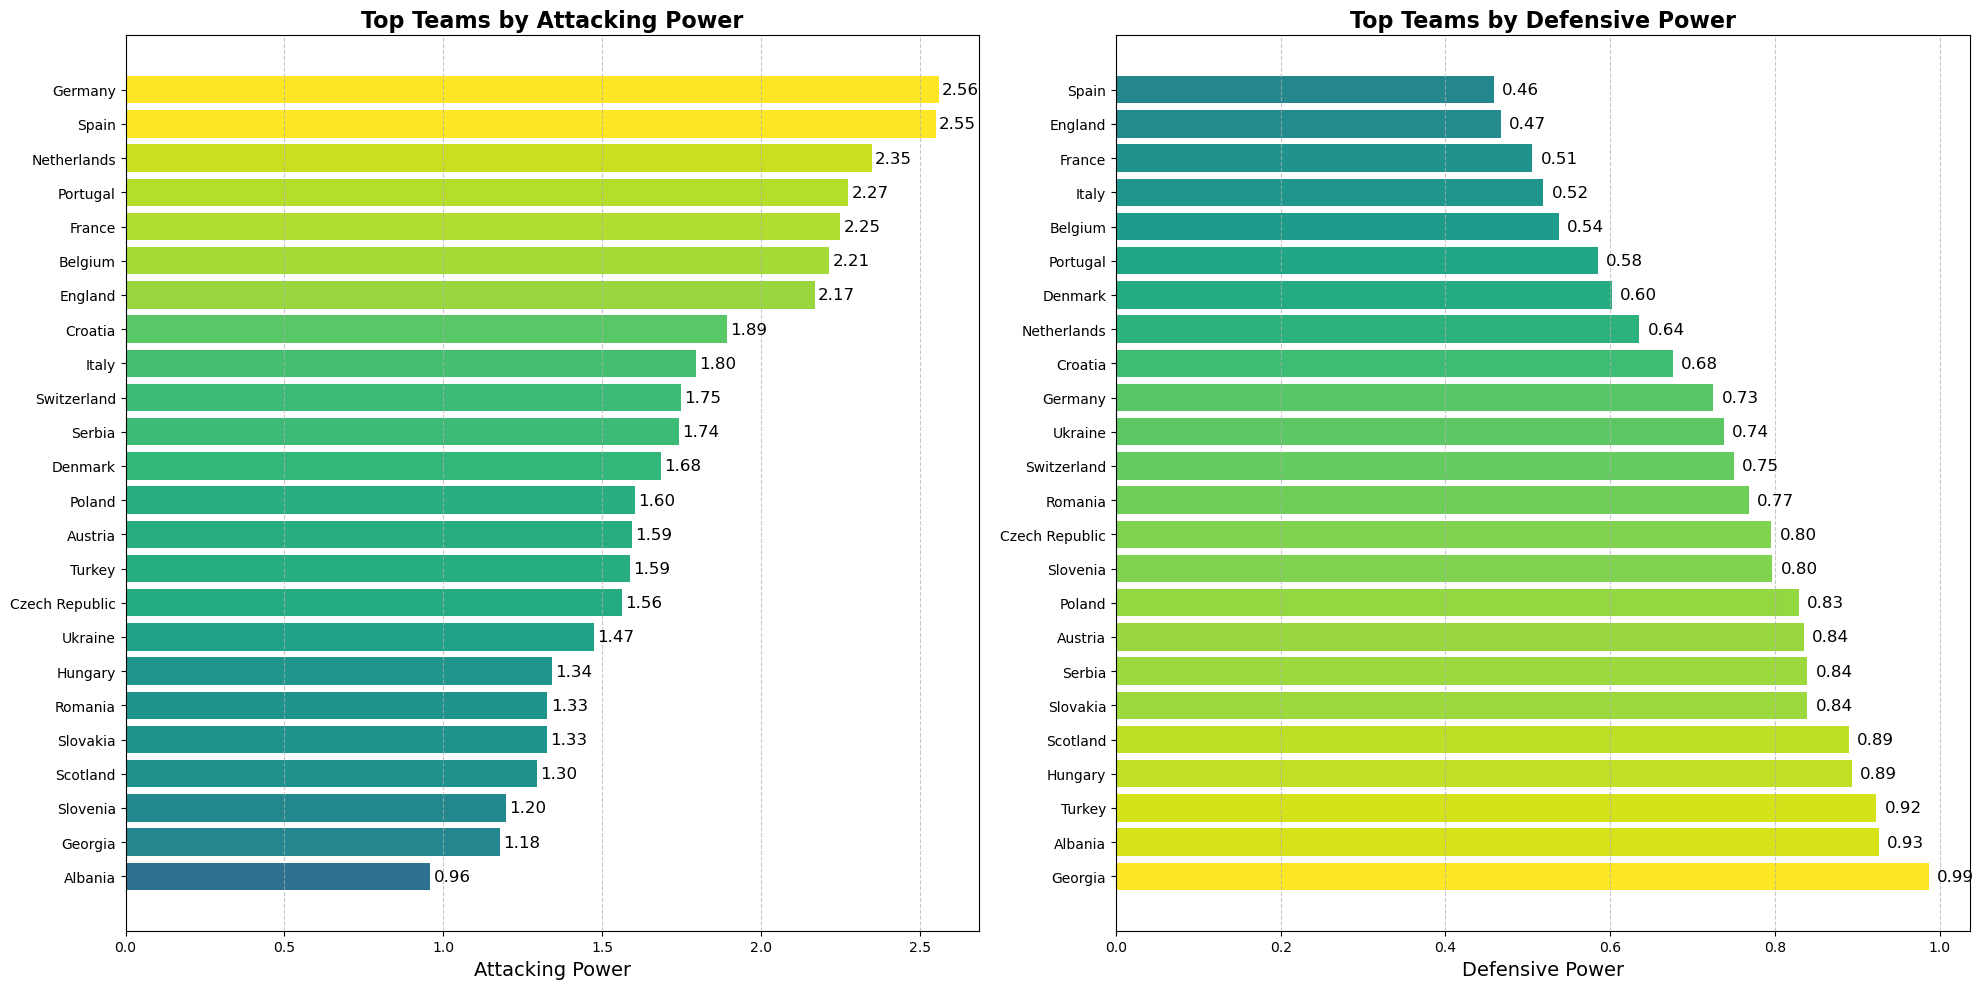

In [14]:
attdef_ranking_europe = attdef[attdef.Team.isin(eurocup_teams)]
plot_top_att_def(attdef_ranking_europe,24)

In [15]:
attdef_ranking_europe

date            Team       att       def  def_position  \
0    2024-06-23         Germany  2.558132  0.725244            37   
1    2024-06-24           Spain  2.548556  0.458797             3   
3    2024-06-25     Netherlands  2.347504  0.635300            19   
4    2024-06-26        Portugal  2.273911  0.584861            14   
7    2024-06-25          France  2.249162  0.505553             6   
8    2024-06-26         Belgium  2.214359  0.537915             9   
9    2024-06-25         England  2.167803  0.467021             4   
12   2024-06-24         Croatia  1.892096  0.676163            26   
15   2024-06-24           Italy  1.796263  0.518989             8   
18   2024-06-23     Switzerland  1.747662  0.750163            43   
19   2024-06-25          Serbia  1.740022  0.839128            63   
23   2024-06-25         Denmark  1.684776  0.601831            16   
32   2024-06-25          Poland  1.604044  0.828754            59   
33   2024-06-25         Austria  1.594715  0.835240            62   
35   2024-06-26          Turkey  1.586500  0.923088            79   
39   2024-06-26  Czech Republic  1.561265  0.795722            51   
50   2024-06-26         Ukraine  1.474243  0.737801            40   
78   2024-06-23         Hungary  1.342773  0.893565            75   
90   2024-06-26         Romania  1.327494  0.768558            45   
91   2024-06-26        Slovakia  1.326854  0.839199            64   
133  2024-06-23        Scotland  1.295363  0.889733            74   
207  2024-06-25        Slovenia  1.196063  0.796803            52   
212  2024-06-26         Georgia  1.177952  0.987056            88   
272  2024-06-24         Albania  0.958692  0.926319            80   

     att_position  
0               1  
1               2  
3               4  
4               5  
7               8  
8               9  
9              10  
12             13  
15             16  
18             19  
19             20  
23             24  
32             33  
33             34  
35             36  
39             40  
50             51  
78             79  
90             91  
91             92  
133           134  
207           208  
212           213  
272           273

Based on this ranking, we can conclude that the teams with the best attack are Germany and Spain. The teams with the best defense are England, Spain, and Italy.

# Goals Expected and Poisson Distribution

The best aspect of this ranking is that we can use it to calculate the expected goals in a match. The expected goals for a team can be calculated as:

$$
Expected Goals=
Attacking Power Team×Defensive Power Opponent$$

Additionally, in non-neutral matches, we have to set a parameter for the advantage of the home team. This parameter adjusts the expected goals to account for the home field advantage.

Let see if the results adjust with Expected goals we predicted, for doing that we consider the results of European tournaments of the last 14 years.

In [16]:
#Creating the reference dataset
df2 = df[(df.date>"2010-09-01") & (df.tournament.isin(["UEFA Euro","UEFA Euro qualification","UEFA Nations League"]))].copy()

# Define the bins
bins = np.array([1.5,2.25, 2.5, 2.75, 3,10])  # adjust this to fit your data
df2['total_score'] = df2['away_score'] + df2['home_score']
df2['total_xG']=df2['XGhome']+df2['XGaway']
df2['total_xG_bin'] = pd.cut(df2['total_xG'], bins)

# Group by the bin and calculate the mean of the 'Goals' column
binned_means = df2.groupby('total_xG_bin')['total_score'].agg(["mean","count"])

print(binned_means)

                  mean  count
total_xG_bin                 
(1.5, 2.25]   2.249322    369
(2.25, 2.5]   2.375328    381
(2.5, 2.75]   2.521127    355
(2.75, 3.0]   2.927273    220
(3.0, 10.0]   3.501502    333


In [17]:
df2

date               home_team               away_team  home_score  \
33959  2010-09-02                  Israel                   Malta         3.0   
33961  2010-09-03                 Andorra                  Russia         0.0   
33962  2010-09-03                 Armenia     Republic of Ireland         0.0   
33963  2010-09-03                 Belgium                 Germany         0.0   
33965  2010-09-03                 England                Bulgaria         4.0   
33966  2010-09-03                 Estonia                   Italy         1.0   
33967  2010-09-03           Faroe Islands                  Serbia         0.0   
33968  2010-09-03                  France                 Belarus         0.0   
33969  2010-09-03                  Greece                 Georgia         1.0   
33970  2010-09-03                 Iceland                  Norway         1.0   
33971  2010-09-03              Kazakhstan                  Turkey         0.0   
33973  2010-09-03                  Latvia                 Croatia         0.0   
33974  2010-09-03           Liechtenstein                   Spain         0.0   
33975  2010-09-03               Lithuania                Scotland         0.0   
33976  2010-09-03              Luxembourg  Bosnia and Herzegovina         0.0   
33977  2010-09-03                 Moldova                 Finland         2.0   
33978  2010-09-03              Montenegro                   Wales         1.0   
33981  2010-09-03                Portugal                  Cyprus         4.0   
33983  2010-09-03                 Romania                 Albania         1.0   
33984  2010-09-03              San Marino             Netherlands         0.0   
33985  2010-09-03                Slovakia         North Macedonia         1.0   
33986  2010-09-03                Slovenia        Northern Ireland         0.0   
33987  2010-09-03                  Sweden                 Hungary         2.0   
34019  2010-09-07                 Albania              Luxembourg         1.0   
34021  2010-09-07                 Austria              Kazakhstan         2.0   
34023  2010-09-07                 Belarus                 Romania         0.0   
34024  2010-09-07  Bosnia and Herzegovina                  France         0.0   
34025  2010-09-07                Bulgaria              Montenegro         0.0   
34028  2010-09-07                 Croatia                  Greece         0.0   
34029  2010-09-07          Czech Republic               Lithuania         0.0   
34030  2010-09-07                 Denmark                 Iceland         1.0   
34033  2010-09-07                 Georgia                  Israel         0.0   
34034  2010-09-07                 Germany              Azerbaijan         6.0   
34035  2010-09-07                 Hungary                 Moldova         2.0   
34036  2010-09-07     Republic of Ireland                 Andorra         3.0   
34037  2010-09-07                   Italy           Faroe Islands         5.0   
34041  2010-09-07         North Macedonia                 Armenia         2.0   
34042  2010-09-07                   Malta                  Latvia         0.0   
34044  2010-09-07             Netherlands                 Finland         2.0   
34045  2010-09-07                  Norway                Portugal         1.0   
34049  2010-09-07                  Russia                Slovakia         0.0   
34050  2010-09-07                Scotland           Liechtenstein         2.0   
34051  2010-09-07                  Serbia                Slovenia         1.0   
34052  2010-09-07                  Sweden              San Marino         6.0   
34053  2010-09-07             Switzerland                 England         1.0   
34054  2010-09-07                  Turkey                 Belgium         3.0   
34111  2010-10-08                 Albania  Bosnia and Herzegovina         1.0   
34112  2010-10-08                 Andorra         North Macedonia         0.0   
34113  2010-10-08                 Armenia   

In [18]:
df2.columns


Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'Elo_h_after',
       'Elo_a_after', 'Elo_h_before', 'Elo_a_before', 'probH', 'probA',
       'att_h_after', 'att_a_after', 'att_h_before', 'att_a_before',
       'def_h_after', 'def_a_after', 'def_h_before', 'def_a_before', 'XGhome',
       'XGaway', 'total_score', 'total_xG', 'total_xG_bin'],
      dtype='object')

In [19]:
df2['year']=df2['date'].apply(lambda x: int(x[:4]))
df2

date               home_team               away_team  home_score  \
33959  2010-09-02                  Israel                   Malta         3.0   
33961  2010-09-03                 Andorra                  Russia         0.0   
33962  2010-09-03                 Armenia     Republic of Ireland         0.0   
33963  2010-09-03                 Belgium                 Germany         0.0   
33965  2010-09-03                 England                Bulgaria         4.0   
33966  2010-09-03                 Estonia                   Italy         1.0   
33967  2010-09-03           Faroe Islands                  Serbia         0.0   
33968  2010-09-03                  France                 Belarus         0.0   
33969  2010-09-03                  Greece                 Georgia         1.0   
33970  2010-09-03                 Iceland                  Norway         1.0   
33971  2010-09-03              Kazakhstan                  Turkey         0.0   
33973  2010-09-03                  Latvia                 Croatia         0.0   
33974  2010-09-03           Liechtenstein                   Spain         0.0   
33975  2010-09-03               Lithuania                Scotland         0.0   
33976  2010-09-03              Luxembourg  Bosnia and Herzegovina         0.0   
33977  2010-09-03                 Moldova                 Finland         2.0   
33978  2010-09-03              Montenegro                   Wales         1.0   
33981  2010-09-03                Portugal                  Cyprus         4.0   
33983  2010-09-03                 Romania                 Albania         1.0   
33984  2010-09-03              San Marino             Netherlands         0.0   
33985  2010-09-03                Slovakia         North Macedonia         1.0   
33986  2010-09-03                Slovenia        Northern Ireland         0.0   
33987  2010-09-03                  Sweden                 Hungary         2.0   
34019  2010-09-07                 Albania              Luxembourg         1.0   
34021  2010-09-07                 Austria              Kazakhstan         2.0   
34023  2010-09-07                 Belarus                 Romania         0.0   
34024  2010-09-07  Bosnia and Herzegovina                  France         0.0   
34025  2010-09-07                Bulgaria              Montenegro         0.0   
34028  2010-09-07                 Croatia                  Greece         0.0   
34029  2010-09-07          Czech Republic               Lithuania         0.0   
34030  2010-09-07                 Denmark                 Iceland         1.0   
34033  2010-09-07                 Georgia                  Israel         0.0   
34034  2010-09-07                 Germany              Azerbaijan         6.0   
34035  2010-09-07                 Hungary                 Moldova         2.0   
34036  2010-09-07     Republic of Ireland                 Andorra         3.0   
34037  2010-09-07                   Italy           Faroe Islands         5.0   
34041  2010-09-07         North Macedonia                 Armenia         2.0   
34042  2010-09-07                   Malta                  Latvia         0.0   
34044  2010-09-07             Netherlands                 Finland         2.0   
34045  2010-09-07                  Norway                Portugal         1.0   
34049  2010-09-07                  Russia                Slovakia         0.0   
34050  2010-09-07                Scotland           Liechtenstein         2.0   
34051  2010-09-07                  Serbia                Slovenia         1.0   
34052  2010-09-07                  Sweden              San Marino         6.0   
34053  2010-09-07             Switzerland                 England         1.0   
34054  2010-09-07                  Turkey                 Belgium         3.0   
34111  2010-10-08                 Albania  Bosnia and Herzegovina         1.0   
34112  2010-10-08                 Andorra         North Macedonia         0.0   
34113  2010-10-08                 Armenia   

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1658 entries, 33959 to 47339
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   date          1658 non-null   object  
 1   home_team     1658 non-null   object  
 2   away_team     1658 non-null   object  
 3   home_score    1658 non-null   float64 
 4   away_score    1658 non-null   float64 
 5   tournament    1658 non-null   object  
 6   city          1658 non-null   object  
 7   country       1658 non-null   object  
 8   neutral       1658 non-null   bool    
 9   Elo_h_after   1658 non-null   float64 
 10  Elo_a_after   1658 non-null   float64 
 11  Elo_h_before  1658 non-null   float64 
 12  Elo_a_before  1658 non-null   float64 
 13  probH         1658 non-null   float64 
 14  probA         1658 non-null   float64 
 15  att_h_after   1658 non-null   float64 
 16  att_a_after   1658 non-null   float64 
 17  att_h_before  1658 non-null   float64 
 18  att_a_be

In [21]:
df2['home_diff_elo']=df2['Elo_h_after']-df2['Elo_a_after']
df2['away_diff_elo']=df2['Elo_a_after']-df2['Elo_h_after']
df2

date               home_team               away_team  home_score  \
33959  2010-09-02                  Israel                   Malta         3.0   
33961  2010-09-03                 Andorra                  Russia         0.0   
33962  2010-09-03                 Armenia     Republic of Ireland         0.0   
33963  2010-09-03                 Belgium                 Germany         0.0   
33965  2010-09-03                 England                Bulgaria         4.0   
33966  2010-09-03                 Estonia                   Italy         1.0   
33967  2010-09-03           Faroe Islands                  Serbia         0.0   
33968  2010-09-03                  France                 Belarus         0.0   
33969  2010-09-03                  Greece                 Georgia         1.0   
33970  2010-09-03                 Iceland                  Norway         1.0   
33971  2010-09-03              Kazakhstan                  Turkey         0.0   
33973  2010-09-03                  Latvia                 Croatia         0.0   
33974  2010-09-03           Liechtenstein                   Spain         0.0   
33975  2010-09-03               Lithuania                Scotland         0.0   
33976  2010-09-03              Luxembourg  Bosnia and Herzegovina         0.0   
33977  2010-09-03                 Moldova                 Finland         2.0   
33978  2010-09-03              Montenegro                   Wales         1.0   
33981  2010-09-03                Portugal                  Cyprus         4.0   
33983  2010-09-03                 Romania                 Albania         1.0   
33984  2010-09-03              San Marino             Netherlands         0.0   
33985  2010-09-03                Slovakia         North Macedonia         1.0   
33986  2010-09-03                Slovenia        Northern Ireland         0.0   
33987  2010-09-03                  Sweden                 Hungary         2.0   
34019  2010-09-07                 Albania              Luxembourg         1.0   
34021  2010-09-07                 Austria              Kazakhstan         2.0   
34023  2010-09-07                 Belarus                 Romania         0.0   
34024  2010-09-07  Bosnia and Herzegovina                  France         0.0   
34025  2010-09-07                Bulgaria              Montenegro         0.0   
34028  2010-09-07                 Croatia                  Greece         0.0   
34029  2010-09-07          Czech Republic               Lithuania         0.0   
34030  2010-09-07                 Denmark                 Iceland         1.0   
34033  2010-09-07                 Georgia                  Israel         0.0   
34034  2010-09-07                 Germany              Azerbaijan         6.0   
34035  2010-09-07                 Hungary                 Moldova         2.0   
34036  2010-09-07     Republic of Ireland                 Andorra         3.0   
34037  2010-09-07                   Italy           Faroe Islands         5.0   
34041  2010-09-07         North Macedonia                 Armenia         2.0   
34042  2010-09-07                   Malta                  Latvia         0.0   
34044  2010-09-07             Netherlands                 Finland         2.0   
34045  2010-09-07                  Norway                Portugal         1.0   
34049  2010-09-07                  Russia                Slovakia         0.0   
34050  2010-09-07                Scotland           Liechtenstein         2.0   
34051  2010-09-07                  Serbia                Slovenia         1.0   
34052  2010-09-07                  Sweden              San Marino         6.0   
34053  2010-09-07             Switzerland                 England         1.0   
34054  2010-09-07                  Turkey                 Belgium         3.0   
34111  2010-10-08                 Albania  Bosnia and Herzegovina         1.0   
34112  2010-10-08                 Andorra         North Macedonia         0.0   
34113  2010-10-08                 Armenia   

In [22]:
aP_teams = {}
for idx, match in df2.iterrows():
    home_team = match["home_team"]
    away_team = match["away_team"]
    home_score = match["home_score"]
    away_score = match["away_score"]
    
    match_year = int(match['date'][:4])
    if match_year == 2024:
        match_year = 2023

#     if home_team == 'Northern Ireland':
#         home_team = 'Republic of Ireland'

#     if away_team == 'Northern Ireland':
#         away_team = 'Republic of Ireland'

    home_elo_series = df2[(df2['year'] == match_year) & (df2['home_team'] == home_team)]['Elo_h_after']
    away_elo_series = df2[(df2['year'] == match_year) & (df2['away_team'] == away_team)]['Elo_a_after']

    try:
        home_elo = home_elo_series.tolist()[0]
        away_elo = away_elo_series.tolist()[0]
    except:
        continue

    home_diff = home_elo - away_elo
    away_diff = away_elo - home_elo

    if home_team in eurocup_teams:
        if home_team not in aP_teams:
            aP_teams[home_team] = [home_score, 1, [home_score], away_score, [away_score], [home_diff]]
        else:
            aP_teams[home_team][0] += home_score
            aP_teams[home_team][1] += 1
            aP_teams[home_team][2].append(home_score)
            aP_teams[home_team][3] += away_score
            aP_teams[home_team][4].append(away_score)
            aP_teams[home_team][5].append(home_diff)

    if away_team in eurocup_teams:
        if away_team not in aP_teams:
            aP_teams[away_team] = [away_score, 1, [away_score], home_score, [home_score], [away_diff]]
        else:
            aP_teams[away_team][0] += away_score
            aP_teams[away_team][1] += 1
            aP_teams[away_team][2].append(away_score)
            aP_teams[away_team][3] += home_score
            aP_teams[away_team][4].append(home_score)
            aP_teams[away_team][5].append(away_diff)

In [23]:
# Summary of aP and Code Function
# aP: This dictionary ends up containing the average number of goals scored per match for each team considered in euros_list.
# Print Output: For each team, it prints the team name, the average goals per match, and the standard deviation of goals scored.
import statistics
aP = {}
for i in aP_teams.keys():
    aP[i] = aP_teams[i][0] / aP_teams[i][1]

    print(f"{i},{aP[i]},{statistics.stdev(aP_teams[i][2])}")

Belgium,2.4057971014492754,1.7766362845665777
Germany,2.288135593220339,1.848119710423572
England,2.1,1.8189820373422914
Italy,1.7848101265822784,1.482123269692101
Serbia,1.5789473684210527,1.223977246827685
France,1.875,2.0039643250000774
Georgia,1.2622950819672132,1.2234056201748502
Turkey,1.4615384615384615,1.3355350411553588
Croatia,1.6428571428571428,1.3623904214488174
Spain,2.3733333333333335,1.7689005085105858
Scotland,1.576271186440678,1.499464155215507
Portugal,2.1232876712328768,1.8253249747149445
Romania,1.323076923076923,1.2003605227661331
Albania,1.1071428571428572,1.1548879745526117
Netherlands,2.196969696969697,1.8746872311007547
Slovakia,1.196969696969697,1.153185514059568
Slovenia,1.380952380952381,1.337168064672397
Hungary,1.492537313432836,1.3070106341683057
Austria,1.625,1.4085904245475276
Czech Republic,1.373134328358209,1.056521176708736
Denmark,1.671875,1.4148272371958037
Switzerland,1.876923076923077,1.6630891090423823
Poland,1.5833333333333333,1.576218029600016

In [24]:
# Structure of aP_teams
# Key: Team name.
# Value: A list containing:
# Total goals scored by the team ([0]).
# Total number of matches ([1]).
# A list of goals scored in each match ([2]).
# Total goals conceded ([3]).
# A list of goals conceded in each match ([4]).
# A list of ELO rating differences for each match ([5]).


import pprint # Will be used later for some nicer prints 
pprint.pprint(aP_teams["England"])

[147.0,
 70,
 [4.0,
  3.0,
  0.0,
  2.0,
  2.0,
  3.0,
  1.0,
  2.0,
  1.0,
  3.0,
  1.0,
  0.0,
  2.0,
  5.0,
  1.0,
  3.0,
  4.0,
  3.0,
  6.0,
  2.0,
  2.0,
  3.0,
  1.0,
  2.0,
  0.0,
  1.0,
  1.0,
  0.0,
  3.0,
  2.0,
  5.0,
  5.0,
  1.0,
  0.0,
  4.0,
  5.0,
  1.0,
  6.0,
  7.0,
  4.0,
  1.0,
  0.0,
  2.0,
  0.0,
  0.0,
  4.0,
  1.0,
  0.0,
  1.0,
  2.0,
  4.0,
  2.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  3.0,
  2.0,
  2.0,
  4.0,
  7.0,
  1.0,
  3.0,
  2.0,
  1.0,
  1.0,
  1.0,
  0.0],
 50.0,
 [0.0,
  1.0,
  0.0,
  0.0,
  2.0,
  0.0,
  0.0,
  2.0,
  1.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  2.0,
  2.0,
  0.0,
  2.0,
  1.0,
  0.0,
  1.0,
  3.0,
  0.0,
  0.0,
  3.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  4.0,
  1.0,
  3.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0]

In [25]:
mega = [[], []]
for idx, i in enumerate(list(aP_teams.values())):
    mega[1] += (np.array(i[2]) - np.array(len(i[2])*[aP[list(aP_teams.keys())[idx]]])).tolist()
    mega[0] += i[5]

In [26]:
from sklearn.linear_model import LinearRegression

X, y = np.array(mega[0]).reshape(-1, 1), np.array(mega[1]).reshape(-1, 1)


reg = LinearRegression()
reg.fit(X, y)


print(reg.score(X, y))

print(reg.coef_, reg.intercept_)

0.15650648541075995
[[0.00279566]] [-0.28833165]


In [27]:
max(X)

array([852.45])

In [28]:
min(X)

array([-531.88])

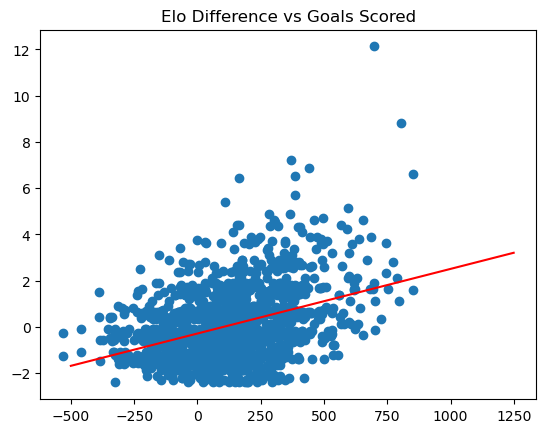

In [29]:
plt.title('Elo Difference vs Goals Scored')
plt.scatter(mega[0], mega[1])
x = np.arange(-500, 1250)
y = x*reg.coef_[0] + reg.intercept_[0]
plt.plot(x, y, color='red')

We can see that the expected goals we created adjust very well to the real number of goals in the matches. So we can use the poisson distribution to predict the results of the matches

The Poisson distribution is defined by the probability mass function:

𝑃(𝑋=𝑘)=𝜆𝑘𝑒−𝜆𝑘!

where:

𝑃(𝑋=𝑘) is the probability of 𝑘 goals being scored, λ is the average number of goals scored in a match.

In our context, 𝜆 represents the average number of goals a team is expected to score.

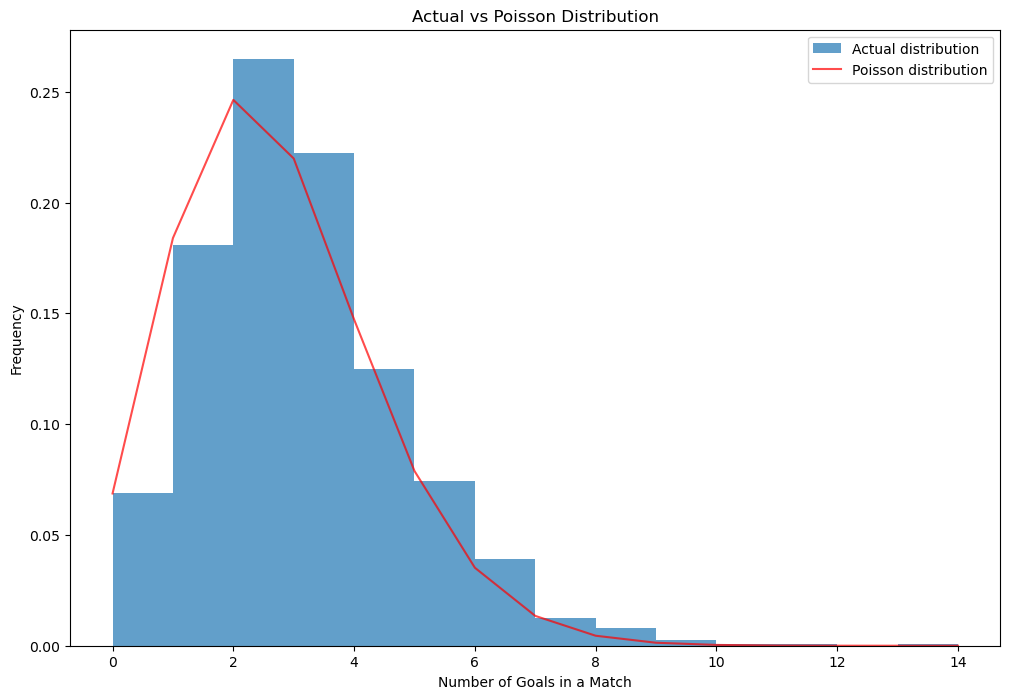

In [30]:
data = df2['total_score']

# Calculate the mean of the data as it will be the lambda (rate parameter) for the Poisson distribution
mu = data.mean()

# Create a range of numbers from 0 to the maximum number of goals in a match (this will be our x-axis)
k = np.arange(0, data.max()+1)

# Create a Poisson distribution with the mean obtained
poisson_pmf = poisson.pmf(k, mu)

plt.figure(figsize=(12,8))

# Plot the actual distribution of goals
plt.hist(data, bins=k, density=True, alpha=0.7, label='Actual distribution')

# Plot the Poisson distribution
plt.plot(k, poisson_pmf, 'r-', alpha=0.7, label='Poisson distribution')

plt.title('Actual vs Poisson Distribution')
plt.xlabel('Number of Goals in a Match')
plt.ylabel('Frequency')
plt.legend()

plt.show()

With the utilization of the given distribution, we can use the probabilities to predict the matches.

In [31]:
def calculate_match_probabilities(team_a_lambda, team_b_lambda, max_goals=10):
    # Create a matrix of zeros
    matrix = np.zeros((max_goals + 1, max_goals + 1))

    # Populate the matrix with probabilities
    for i in range(max_goals + 1):
        for j in range(max_goals + 1):
            matrix[i, j] = poisson.pmf(i, team_a_lambda) * poisson.pmf(j, team_b_lambda)
    
    # Calculate the total goals probabilities
    total_goals_prob = [np.sum(np.diag(matrix[::-1], k)) for k in range(-(max_goals-1), max_goals+1)]

    # Calculate the probability for the specific result
    draw_prob = np.sum(np.diag(matrix))
    away_prob = np.sum(np.triu(matrix, 1))
    local_prob = np.sum(np.tril(matrix, -1))
    
    df_match_goals=pd.DataFrame(matrix)
    highest_value = df_match_goals.max().max()
    max_position = df_match_goals.stack().idxmax()
    h_goals=max_position[0]
    a_goals=max_position[1]
    

    return total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals


For instance, let's consider the inaugural match of the 2024 Euro between Germany and Scotland. Germany boasts an offensive power of 2.58, while Scotland 1.31.

Probability for France: 80.0 %
Probability for Albania: 6.0 %
Probability for draw: 14.000000000000002 %


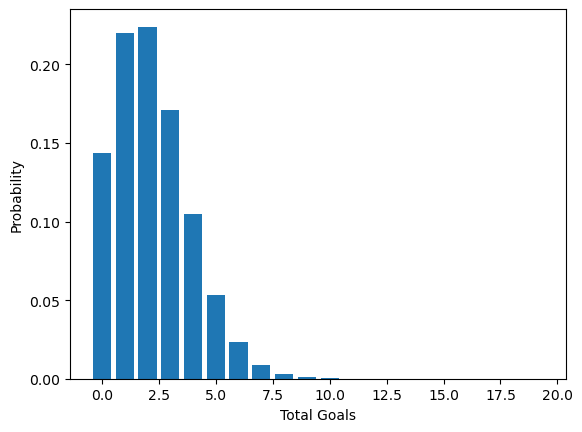

In [32]:
# Example usage
# Albania	1342.140	
# France	1752.570
# Georgia	1.177952	0.987056	
# Spain	2.548556	0.458797

team_a_lambda = 2.548556 * 0.987056
team_b_lambda = 1.177952 * 0.458797
total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals = calculate_match_probabilities(team_a_lambda, team_b_lambda)

# Print the results
'''print("Total goals probabilities:")
for goals, prob in enumerate(total_goals_prob):
    print(f'Probability of total {goals} goals: {prob}')'''


print(f"Probability for France: {round(local_prob,2)*100} %")
print(f"Probability for Albania: {round(away_prob,2)*100} %")
print(f"Probability for draw: {round(draw_prob,2)*100} %")

import matplotlib.pyplot as plt
# Plot the distribution of possible total goals
plt.bar(range(len(total_goals_prob)), total_goals_prob)
plt.xlabel('Total Goals')
plt.ylabel('Probability')
plt.show()

In [33]:
h_goals

2

In [34]:
a_goals

0

In [35]:
max(total_goals_prob)

0.22392614125034904

#  Adjusted Goals Expected with ELO form and Poisson Distribution

In [36]:
# phase1=pd.read_excel('Prediction_template.xlsx',sheet_name='Match predictions')
# phase1=phase1[['Home Team','Away Team','Home_goal','Away_Goal']]
# phase1=phase1.iloc[:36,:]
# phase1

In [37]:
# home_goals = phase1.groupby('Home Team').agg(goals_scored=('Home_goal', 'sum'), goals_against=('Away_Goal', 'sum')).reset_index()
# home_goals.rename(columns={'Home Team': 'Team'}, inplace=True)
# away_goals = phase1.groupby('Away Team').agg(goals_scored=('Away_Goal', 'sum'), goals_against=('Home_goal', 'sum')).reset_index()
# away_goals.rename(columns={'Away Team': 'Team'}, inplace=True)
# teams_pred = pd.concat([home_goals, away_goals]).groupby('Team').sum().reset_index()
# teams_pred

In [38]:
# teams_pred.columns

## Adding euro form

In [39]:
import pandas as pd
euros24_group=pd.read_excel('euroresults.xlsx')
euros24_group

Team  goals_scored  goals_against  points
0            Spain             5              0       9
1          Germany             8              2       7
2          Austria             6              4       6
3           Turkey             5              5       6
4         Portugal             5              3       6
5          England             2              1       5
6           France             2              1       5
7      Switzerland             5              3       5
8            Italy             3              3       4
9          Romania             4              3       4
10         Belgium             2              1       4
11     Netherlands             4              4       4
12        Slovakia             3              3       4
13         Georgia             4              4       4
14         Ukraine             2              4       4
15         Hungary             2              5       3
16        Slovenia             2              2       3
17         Denmark             2              2       3
18          Serbia             1              2       2
19         Croatia             3              6       2
20          Poland             3              6       1
21        Scotland             2              7       1
22         Albania             3              5       1
23  Czech Republic             3              5       1

In [40]:
group16=[
    'Austria',
'England',
'Germany',
'Portugal',
'Romania',
'Spain',
'Belgium',
'Denmark',
'France',
'Italy',
'Switzerland',
'Turkey',
    'Georgia', 
'Netherlands',
'Slovakia',
'Slovenia'] 

group16_eurosteams=euros24_group[euros24_group['Team'].isin(group16)]
group16_eurosteams_sorted = group16_eurosteams.sort_values(by=['points'], ascending=False)
group16_eurosteams_sorted['euro_form'] = (group16_eurosteams_sorted['points']/(group16_eurosteams_sorted['points'].median()))
group16_eurosteams_sorted


Team  goals_scored  goals_against  points  euro_form
0         Spain             5              0       9   2.000000
1       Germany             8              2       7   1.555556
2       Austria             6              4       6   1.333333
3        Turkey             5              5       6   1.333333
4      Portugal             5              3       6   1.333333
5       England             2              1       5   1.111111
6        France             2              1       5   1.111111
7   Switzerland             5              3       5   1.111111
8         Italy             3              3       4   0.888889
9       Romania             4              3       4   0.888889
10      Belgium             2              1       4   0.888889
11  Netherlands             4              4       4   0.888889
12     Slovakia             3              3       4   0.888889
13      Georgia             4              4       4   0.888889
16     Slovenia             2              2       3   0.666667
17      Denmark             2              2       3   0.666667

In [41]:
group16_eurosteams_sorted['points'].median()

4.5

In [42]:
# group16_eurosteams_sorted_predict = pd.merge(group16_eurosteams_sorted, teams_pred[['Team', 'goals_scored', 'goals_against']].add_prefix('predicted_'),left_on="Team", right_on="predicted_Team", how="left")
# group16_eurosteams_sorted_predict['diff_goals_scored']=group16_eurosteams_sorted_predict['goals_scored']-group16_eurosteams_sorted_predict['predicted_goals_scored']
# group16_eurosteams_sorted_predict['diff_goals_agaisnt']=group16_eurosteams_sorted_predict['goals_against']-group16_eurosteams_sorted_predict['predicted_goals_against']
# group16_eurosteams_sorted_predict['avg_goals_scored']=group16_eurosteams_sorted_predict['diff_goals_scored']/3
# group16_eurosteams_sorted_predict['avg_goals_agaisnt']=group16_eurosteams_sorted_predict['diff_goals_agaisnt']/3
# group16_eurosteams_sorted_predict['euro_form']=group16_eurosteams_sorted_predict['points']/9
# group16_eurosteams_sorted_predict['form_goals_scored']=group16_eurosteams_sorted_predict['euro_form']+group16_eurosteams_sorted_predict['avg_goals_scored']
# group16_eurosteams_sorted_predict['form_goals_agaisnt']=group16_eurosteams_sorted_predict['euro_form']+group16_eurosteams_sorted_predict['avg_goals_agaisnt']
# group16_eurosteams_sorted_predict


In [43]:
def calculate_match_probabilities_elo(team_a_lambda, team_b_lambda,home_diff,away_diff, max_goals=10):
    # Create a matrix of zeros
    matrix = np.zeros((max_goals + 1, max_goals + 1))

    # Populate the matrix with probabilities
    for i in range(max_goals + 1):
        for j in range(max_goals + 1):
            matrix[i, j] = poisson.pmf(i, team_a_lambda) * poisson.pmf(j, team_b_lambda)
    
    # Calculate the total goals probabilities
    total_goals_prob = [np.sum(np.diag(matrix[::-1], k)) for k in range(-(max_goals-1), max_goals+1)]

    # Calculate the probability for the specific result
    draw_prob = np.sum(np.diag(matrix))
    away_prob = np.sum(np.triu(matrix, 1))
    local_prob = np.sum(np.tril(matrix, -1))
    
    df_match_goals=pd.DataFrame(matrix)
    highest_value = df_match_goals.max().max()
    max_position = df_match_goals.stack().idxmax()
    #array results so need to convert to int
    h_goals_adjust=int(reg.predict(np.array(home_diff).reshape(-1, 1)))
    a_goals_adjust=int(reg.predict(np.array(away_diff).reshape(-1, 1)))
    h_goals=max_position[0]
    a_goals=max_position[1]

    fin_h_goals=h_goals+h_goals_adjust
    fin_a_goals=a_goals+a_goals_adjust
    if (fin_a_goals==-1):
        adj_sum=abs(h_goals_adjust)+abs(a_goals_adjust)
        fin_h_goals+=adj_sum
        fin_a_goals+=1
    elif (fin_h_goals==-1):
        adj_sum=abs(h_goals_adjust)+abs(a_goals_adjust)
        fin_a_goals+=adj_sum
        fin_h_goals+=1
    

    return total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals

In [44]:
float(elos_ranking_euro[elos_ranking_euro['Team']=='Germany']['Elo'] )

1646.3900000000024

In [45]:

# home_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Germany']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Scotland']['Elo'])
# away_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Scotland']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Germany']['Elo'])
# print(f'home_diff : {home_diff}')
# print(f'away_diff : {away_diff}')

Probability for France: 80.0 %
Probability for Albania: 6.0 %
Probability for draw: 14.000000000000002 %


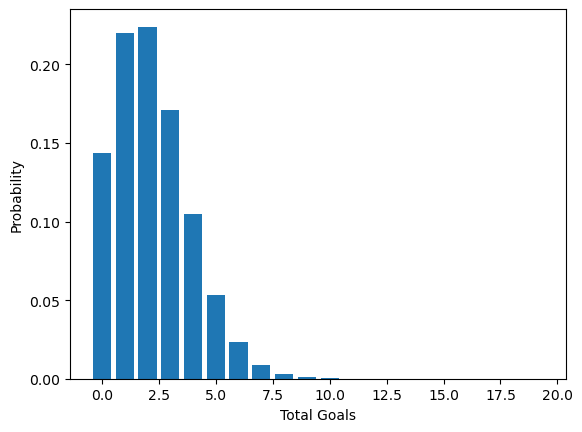

In [46]:
# Example usage
# Albania	1342.140	
# France	1752.570
# Georgia	1.177952	0.987056	
# Spain	2.548556	0.458797

team_a_lambda = 2.548556 * 0.987056
team_b_lambda = 1.177952 * 0.458797
home_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Spain']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Georgia']['Elo'])
away_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Georgia']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='France']['Elo'])
total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals = calculate_match_probabilities_elo(team_a_lambda, team_b_lambda,home_diff,away_diff)



# Print the results
'''print("Total goals probabilities:")
for goals, prob in enumerate(total_goals_prob):
    print(f'Probability of total {goals} goals: {prob}')'''


print(f"Probability for France: {round(local_prob,2)*100} %")
print(f"Probability for Albania: {round(away_prob,2)*100} %")
print(f"Probability for draw: {round(draw_prob,2)*100} %")

import matplotlib.pyplot as plt
# Plot the distribution of possible total goals
plt.bar(range(len(total_goals_prob)), total_goals_prob)
plt.xlabel('Total Goals')
plt.ylabel('Probability')
plt.show()

In [47]:
h_goals,a_goals

(2, 0)

In [48]:
fin_h_goals,fin_a_goals

(3, 0)

Probability for France: 96.0 %
Probability for Albania: 1.0 %
Probability for draw: 2.0 %


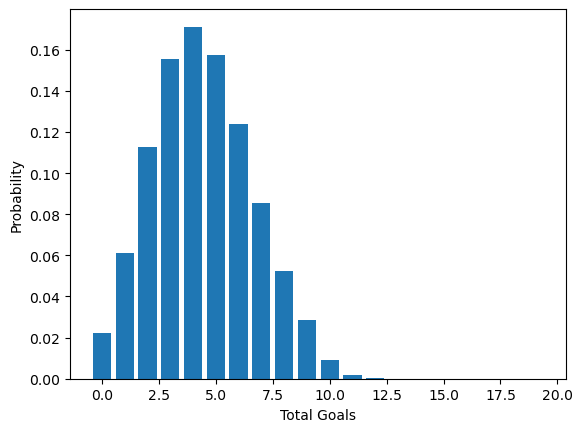

In [49]:
# Example usage
# Georgia	1389.450	
# Spain	1713.675	
# Georgia	1.177952	0.987056	
# Spain	2.548556	0.458797

team_a_lambda = 2.548556 * 0.987056*2.000000
team_b_lambda = 1.177952 * 0.458797*0.888889
home_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Spain']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Georgia']['Elo'])
away_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Georgia']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Spain']['Elo'])
total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals = calculate_match_probabilities_elo(team_a_lambda, team_b_lambda,home_diff,away_diff)


# Print the results
'''print("Total goals probabilities:")
for goals, prob in enumerate(total_goals_prob):
    print(f'Probability of total {goals} goals: {prob}')'''


print(f"Probability for France: {round(local_prob,2)*100} %")
print(f"Probability for Albania: {round(away_prob,2)*100} %")
print(f"Probability for draw: {round(draw_prob,2)*100} %")

import matplotlib.pyplot as plt
# Plot the distribution of possible total goals
plt.bar(range(len(total_goals_prob)), total_goals_prob)
plt.xlabel('Total Goals')
plt.ylabel('Probability')
plt.show()

In [50]:
h_goals,a_goals

(5, 0)

In [51]:
fin_h_goals,fin_a_goals

(6, 0)

In [54]:
for x in range(-532,853):
    h_goals_adjust=int(reg.predict(np.array(x).reshape(-1, 1)))
    print(h_goals_adjust,x)

-1 -532
-1 -531
-1 -530
-1 -529
-1 -528
-1 -527
-1 -526
-1 -525
-1 -524
-1 -523
-1 -522
-1 -521
-1 -520
-1 -519
-1 -518
-1 -517
-1 -516
-1 -515
-1 -514
-1 -513
-1 -512
-1 -511
-1 -510
-1 -509
-1 -508
-1 -507
-1 -506
-1 -505
-1 -504
-1 -503
-1 -502
-1 -501
-1 -500
-1 -499
-1 -498
-1 -497
-1 -496
-1 -495
-1 -494
-1 -493
-1 -492
-1 -491
-1 -490
-1 -489
-1 -488
-1 -487
-1 -486
-1 -485
-1 -484
-1 -483
-1 -482
-1 -481
-1 -480
-1 -479
-1 -478
-1 -477
-1 -476
-1 -475
-1 -474
-1 -473
-1 -472
-1 -471
-1 -470
-1 -469
-1 -468
-1 -467
-1 -466
-1 -465
-1 -464
-1 -463
-1 -462
-1 -461
-1 -460
-1 -459
-1 -458
-1 -457
-1 -456
-1 -455
-1 -454
-1 -453
-1 -452
-1 -451
-1 -450
-1 -449
-1 -448
-1 -447
-1 -446
-1 -445
-1 -444
-1 -443
-1 -442
-1 -441
-1 -440
-1 -439
-1 -438
-1 -437
-1 -436
-1 -435
-1 -434
-1 -433
-1 -432
-1 -431
-1 -430
-1 -429
-1 -428
-1 -427
-1 -426
-1 -425
-1 -424
-1 -423
-1 -422
-1 -421
-1 -420
-1 -419
-1 -418
-1 -417
-1 -416
-1 -415
-1 -414
-1 -413
-1 -412
-1 -411
-1 -410
-1 -409
-1 -408


Probability for France: 7.000000000000001 %
Probability for Albania: 76.0 %
Probability for draw: 17.0 %


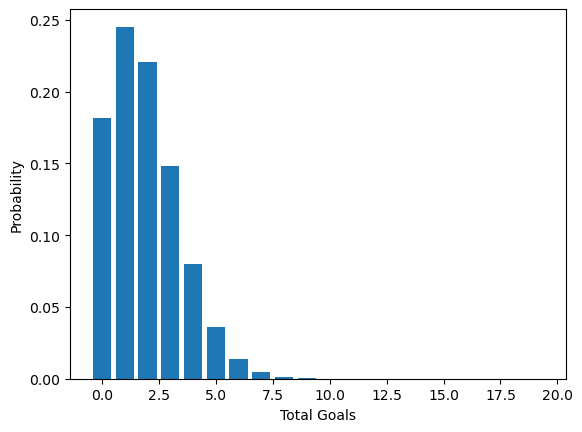

In [55]:
# Example usage
# Albania	1342.140	
# France	1752.570
# Albania	0.929605	0.945796	
# France	2.316062	0.543255	


team_b_lambda = 2.316062 * 0.945796 
team_a_lambda = 0.543255 * 0.929605
away_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='France']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Albania']['Elo'])
home_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Albania']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='France']['Elo'])
total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals = calculate_match_probabilities_elo(team_a_lambda, team_b_lambda,home_diff,away_diff)



# Print the results
'''print("Total goals probabilities:")
for goals, prob in enumerate(total_goals_prob):
    print(f'Probability of total {goals} goals: {prob}')'''


print(f"Probability for France: {round(local_prob,2)*100} %")
print(f"Probability for Albania: {round(away_prob,2)*100} %")
print(f"Probability for draw: {round(draw_prob,2)*100} %")

import matplotlib.pyplot as plt
# Plot the distribution of possible total goals
plt.bar(range(len(total_goals_prob)), total_goals_prob)
plt.xlabel('Total Goals')
plt.ylabel('Probability')
plt.show()

In [56]:
h_goals,a_goals

(0, 2)

In [57]:
fin_h_goals,fin_a_goals

(0, 3)

In [58]:
team_a_lambda = 2.316062 * 0.945796 
team_b_lambda = 0.543255 * 0.929605
total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals = calculate_match_probabilities_elo(team_a_lambda, team_b_lambda,home_diff=532,away_diff=-532)


In [59]:
h_goals,a_goals

(2, 0)

In [60]:
fin_h_goals,fin_a_goals

(5, 0)

In [61]:
team_a_lambda = 2.316062 * 0.945796 
team_b_lambda = 0.543255 * 0.929605
total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals= calculate_match_probabilities_elo(team_b_lambda, team_a_lambda,home_diff=-532,away_diff=532)


In [62]:
h_goals,a_goals

(0, 2)

In [63]:
fin_h_goals,fin_a_goals

(0, 5)

Now it is time to validate if the probabilities given by the poisson distribution are accurate or not

In [64]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1658 entries, 33959 to 47339
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           1658 non-null   object  
 1   home_team      1658 non-null   object  
 2   away_team      1658 non-null   object  
 3   home_score     1658 non-null   float64 
 4   away_score     1658 non-null   float64 
 5   tournament     1658 non-null   object  
 6   city           1658 non-null   object  
 7   country        1658 non-null   object  
 8   neutral        1658 non-null   bool    
 9   Elo_h_after    1658 non-null   float64 
 10  Elo_a_after    1658 non-null   float64 
 11  Elo_h_before   1658 non-null   float64 
 12  Elo_a_before   1658 non-null   float64 
 13  probH          1658 non-null   float64 
 14  probA          1658 non-null   float64 
 15  att_h_after    1658 non-null   float64 
 16  att_a_after    1658 non-null   float64 
 17  att_h_before   1658 non-null   fl

In [65]:
df_euro=df2.copy()
# Function to apply to each row of the DataFrame
def apply_calculation_elo(row):
#     home_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Germany']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Scotland']['Elo'])
#     away_diff = float(elos_ranking_euro[elos_ranking_euro['Team']=='Scotland']['Elo']) - float(elos_ranking_euro[elos_ranking_euro['Team']=='Germany']['Elo'])
    total_goals_prob, draw_prob, away_prob, local_prob,h_goals,a_goals,fin_h_goals,fin_a_goals = calculate_match_probabilities_elo(row['XGhome'], row['XGaway'],row['home_diff_elo'],row['away_diff_elo'])
    return pd.Series({
        'total_goals_prob': total_goals_prob,
        'draw_prob': draw_prob,
        'away_prob': away_prob,
        'local_prob': local_prob,
        'home_goals': h_goals,
        'away_goals': a_goals,
         'home_goals_elo': fin_h_goals,
        'away_goals_elo': fin_a_goals,
    })

# Apply the function to each row
calculated_variables = df_euro.apply(apply_calculation_elo, axis=1)

# Concatenate the result with the original DataFrame
matches_df = pd.concat([df_euro, calculated_variables], axis=1)

df_euro[['total_goals_prob', 'draw_prob', 'away_prob', 'local_prob','home_goals' ,'away_goals','home_goals_elo','away_goals_elo']] = df_euro[['XGhome','XGaway','home_diff_elo','away_diff_elo']].apply(apply_calculation_elo, axis=1)

# Iterate over each row in the DataFrame
for index, row in df_euro.iterrows():
    # Iterate over each element in the 'total_goals_prob' list
    for i, prob in enumerate(row['total_goals_prob']):
        # Create new column with the name 'prob_index_goals_i' and assign the corresponding value
        df_euro.at[index, f'prob_index_goals_{i}'] = prob

<Figure size 1200x600 with 0 Axes>

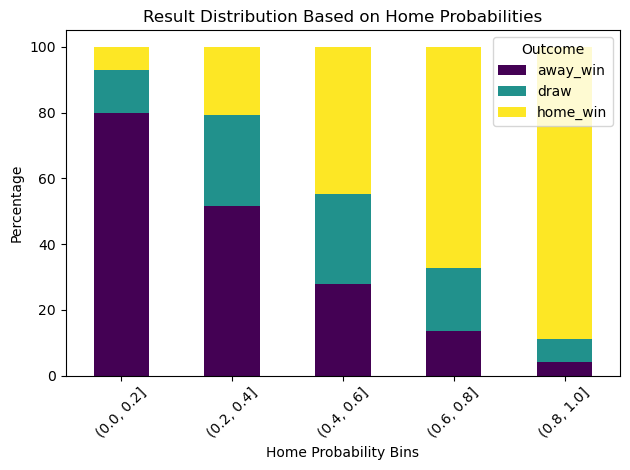

In [66]:
# Compute the actual outcome based on the home and away scores
df_euro['result'] = np.where(df_euro['home_score'] > df_euro['away_score'], 'home_win',
                                 np.where(df_euro['home_score'] == df_euro['away_score'], 'draw', 'away_win'))

df_euro['home_win_flag'] = np.where(df_euro['result']=='home_win', 1,0)
df_euro['draw_flag'] = np.where(df_euro['result']=='draw', 1,0)
df_euro['away_win_flag'] = np.where(df_euro['result']=='away_win', 1,0)
# Define bins for grouping based on predicted probabilities (adjust as needed)
bins = [0, 0.2, 0.4,0.6, 0.8,1]

# Create a new column indicating the bin for each match based on predicted probabilities
df_euro['probability_bin'] = pd.cut(df_euro['local_prob'], bins=bins)

# Group the DataFrame by the probability bins and compute the percentage of actual outcomes within each group
result_distribution = df_euro.groupby('probability_bin')['result'].value_counts(normalize=True).unstack() * 100

# Plotting the result distribution based on home probabilities
plt.figure(figsize=(12, 6))
result_distribution.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Result Distribution Based on Home Probabilities')
plt.xlabel('Home Probability Bins')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Outcome')
plt.tight_layout()

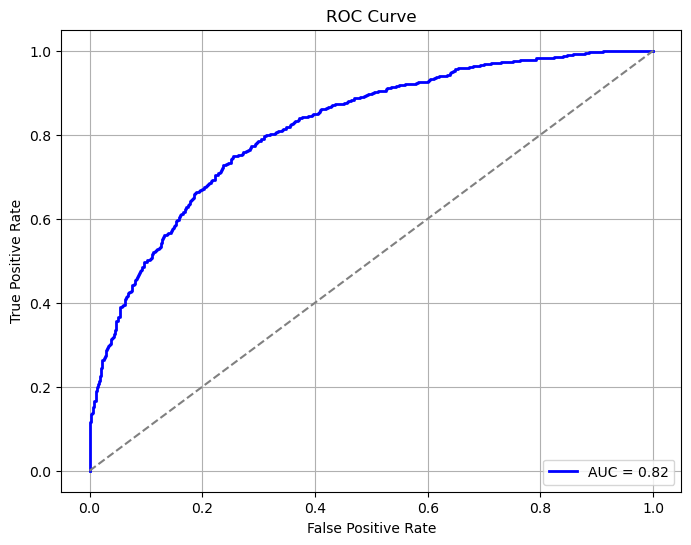

AUC: 0.82


In [67]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(df_euro['home_win_flag'], df_euro['local_prob'])

# Compute AUC
auc = roc_auc_score(df_euro['home_win_flag'], df_euro['local_prob'])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"AUC: {auc:.2f}")

It can be seen that the probabilities for home winning are working good.

In [68]:
# Create a new column indicating the bin for each match based on predicted probabilities
bins = [0, 0.15, 0.3,0.6,1]
df_euro['probability_bin'] = pd.cut(df_euro['away_prob'], bins=bins)

# Group the DataFrame by the probability bins and compute the percentage of actual outcomes within each group
result_distribution = df_euro.groupby('probability_bin')['result'].value_counts(normalize=True).unstack() * 100
print(result_distribution)
# Compute AUC
auc_away = roc_auc_score(df_euro['away_win_flag'], df_euro['away_prob'])

print(f"AUC: {auc_away:.2f}")

result            away_win       draw   home_win
probability_bin                                 
(0.0, 0.15]       8.052434  14.044944  77.902622
(0.15, 0.3]      25.279642  27.516779  47.203579
(0.3, 0.6]       53.179191  26.782274  20.038536
(0.6, 1.0]       87.341772   7.594937   5.063291
AUC: 0.81


It can be said the same for the away probabilities, 
so we can conclude that this predictions are relative good for the matches in Euro.

# 2024 Euro Prediction

Once we have the probabilities, we can finally use it to predict the results of the 2024 Euro. Let see it.

In [69]:
matches_data = [
    # Grupo 16
    {"Grupo": "16", "Home_Team": "Switzerland", "Away_Team": "Italy"},
    {"Grupo": "16", "Home_Team": "England", "Away_Team": "Slovakia"},
    {"Grupo": "16", "Home_Team": "Germany", "Away_Team": "Denmark"},
    {"Grupo": "16", "Home_Team": "Spain", "Away_Team": "Georgia"},
    {"Grupo": "16", "Home_Team": "France", "Away_Team": "Belgium"},
    {"Grupo": "16", "Home_Team": "Portugal", "Away_Team": "Slovenia"},
    {"Grupo": "16", "Home_Team": "Romania", "Away_Team": "Netherlands"},
    {"Grupo": "16", "Home_Team": "Austria", "Away_Team": "Turkey"},
    
    #Grupo 8
    {"Grupo": "8", "Home_Team": "Italy", "Away_Team": "England"},
    {"Grupo": "8", "Home_Team": "Germany", "Away_Team": "Spain"},
    {"Grupo": "8", "Home_Team": "France", "Away_Team": "Portugal"},
    {"Grupo": "8", "Home_Team": "Netherlands", "Away_Team": "Austria"},
    
    
    
#     {"Grupo": "16", "Home_Team": "Slovenia", "Away_Team": "Denmark"},
#     {"Grupo": "16", "Home_Team": "Serbia", "Away_Team": "England"},
#     {"Grupo": "16", "Home_Team": "Slovenia", "Away_Team": "Serbia"},
#     {"Grupo": "16", "Home_Team": "Denmark", "Away_Team": "England"},
#     {"Grupo": "16", "Home_Team": "England", "Away_Team": "Slovenia"},
#     {"Grupo": "16", "Home_Team": "Denmark", "Away_Team": "Serbia"},
#     # Grupo D
#     {"Grupo": "16", "Home_Team": "Poland", "Away_Team": "Netherlands"},
#     {"Grupo": "16", "Home_Team": "Austria", "Away_Team": "France"},
#     {"Grupo": "16", "Home_Team": "Poland", "Away_Team": "Austria"},
#     {"Grupo": "16", "Home_Team": "Netherlands", "Away_Team": "France"},
#     {"Grupo": "D", "Home_Team": "Netherlands", "Away_Team": "Austria"},
#     {"Grupo": "D", "Home_Team": "France", "Away_Team": "Poland"},
#     # Grupo E
#     {"Grupo": "E", "Home_Team": "Romania", "Away_Team": "Ukraine"},
#     {"Grupo": "E", "Home_Team": "Belgium", "Away_Team": "Slovakia"},
#     {"Grupo": "E", "Home_Team": "Slovakia", "Away_Team": "Ukraine"},
#     {"Grupo": "E", "Home_Team": "Belgium", "Away_Team": "Romania"},
#     {"Grupo": "E", "Home_Team": "Slovakia", "Away_Team": "Romania"},
#     {"Grupo": "E", "Home_Team": "Ukraine", "Away_Team": "Belgium"},
#     # Grupo F
#     {"Grupo": "F", "Home_Team": "Turkey", "Away_Team": "Georgia"},
#     {"Grupo": "F", "Home_Team": "Portugal", "Away_Team": "Czech Republic"},
#     {"Grupo": "F", "Home_Team": "Georgia", "Away_Team": "Czech Republic"},
#     {"Grupo": "F", "Home_Team": "Turkey", "Away_Team": "Portugal"},
#     {"Grupo": "F", "Home_Team": "Georgia", "Away_Team": "Portugal"},
#     {"Grupo": "F", "Home_Team": "Czech Republic", "Away_Team": "Turkey"},
]

# Create a dataframe
matches_df = pd.DataFrame(matches_data)

In [70]:
matches_df

Grupo    Home_Team    Away_Team
0     16  Switzerland        Italy
1     16      England     Slovakia
2     16      Germany      Denmark
3     16        Spain      Georgia
4     16       France      Belgium
5     16     Portugal     Slovenia
6     16      Romania  Netherlands
7     16      Austria       Turkey
8      8        Italy      England
9      8      Germany        Spain
10     8       France     Portugal
11     8  Netherlands      Austria

In [71]:
elos

date                              Team       Elo  position
0    2024-06-25                         Argentina  1783.185         1
1    2024-06-25                            France  1742.770         2
2    2024-06-24                             Spain  1713.675         3
3    2024-06-24                            Brazil  1694.300         4
4    2024-06-25                           England  1669.975         5
5    2024-06-25                       Netherlands  1667.360         6
6    2024-06-24                          Colombia  1658.545         7
7    2024-06-26                           Belgium  1649.525         8
8    2024-06-23                           Germany  1646.390         9
9    2024-06-24                             Italy  1643.220        10
10   2024-06-23                           Uruguay  1643.115        11
11   2024-06-26                          Portugal  1637.725        12
12   2024-06-11                             Japan  1606.200        13
13   2024-06-24                           Croatia  1600.850        14
14   2024-06-11                              Iran  1579.440        15
15   2024-06-09                           Senegal  1572.650        16
16   2024-06-23                       Switzerland  1570.075        17
17   2024-06-22                            Mexico  1566.000        18
18   2024-06-23                     United States  1557.835        19
19   2024-06-11                           Morocco  1557.500        20
20   2024-06-11                         Australia  1552.985        21
21   2024-06-11                       South Korea  1549.620        22
22   2024-06-25                           Austria  1544.710        23
23   2024-06-25                           Denmark  1544.270        24
24   2024-06-26                           Ukraine  1524.660        25
25   2024-06-22                           Ecuador  1523.380        26
26   2024-06-11                             Qatar  1520.015        27
27   2024-06-11                       Ivory Coast  1517.195        28
28   2024-06-07                            Russia  1511.040        29
29   2024-06-24                        Costa Rica  1499.880        30
30   2024-06-23                           Hungary  1496.465        31
31   1999-12-23                        Yugoslavia  1491.810        32
32   2024-06-26                            Turkey  1490.005        33
33   2024-06-10                             Egypt  1487.195        34
34   2024-06-25                            Serbia  1485.295        35
35   2024-06-11                        Uzbekistan  1483.150        36
36   2024-06-25                            Poland  1479.350        37
37   2024-06-08                            Sweden  1479.280        38
38   2024-06-11                              Iraq  1475.655        39
39   2024-06-22                         Venezuela  1474.090        40
40   2024-06-25                             Chile  1472.060        41
41   2024-06-25                              Peru  1470.975        42
42   2024-06-11                      Saudi Arabia  1466.380        43
43   2024-06-09                             Wales  1462.595        44
44   2024-06-10                           Algeria  1459.885        45
45   2024-06-10                           Nigeria  1459.805        46
46   2024-06-25                            Canada  1457.280        47
47   1992-11-14                    Czechoslovakia  1454.940        48
48   2024-06-09                           Tunisia  1454.880        49
49   2024-06-11                          Cameroon  1451.485        50
50   2024-06-11                            Jordan  1450.925        51
51   2024-06-21                       New Zealand  1449.895        52
52   2024-06-11                            Greece  1449.440        53
53   2024-06-23                          Scotland  1445.070        54
54   2024-06-26                    Czech Republic  1444.845        55
55   2024-06-08                            Norway  1444.285        56
56   2024-06-25      

In [72]:
# merged_df = pd.merge(matches_df, attdef[["Team", "att", "def"]].add_prefix('Home_'),left_on="Home_Team", right_on="Home_Team", how="left")
# merged_df_elo = pd.merge(merged_df, elos[["Team","Elo"]].add_prefix('Home_'),left_on="Home_Team", right_on="Home_Team", how="left")
# merged_df_elo_form = pd.merge(merged_df_elo, group16_eurosteams_sorted_predict[['Team','form_goals_scored','form_goals_agaisnt']].add_prefix('Home_'),left_on="Home_Team", right_on="Home_Team", how="left")
# group_matches_elo = pd.merge(merged_df_elo_form, attdef[["Team", "att", "def"]].add_prefix('Away_'),left_on="Away_Team", right_on="Away_Team", how="left")
# group_matches_form= pd.merge(group_matches_elo, elos[["Team","Elo"]].add_prefix('Away_'),left_on="Away_Team", right_on="Away_Team", how="left")
# group_matches = pd.merge(group_matches_form, group16_eurosteams_sorted_predict[['Team','form_goals_scored','form_goals_agaisnt']].add_prefix('Away_'),left_on="Away_Team", right_on="Away_Team", how="left")
# # group_matches['form_Home_att']=group_matches['Home_att']+group_matches['Home_form_goals_scored']
# # group_matches['form_Home_def']=group_matches['Home_def']+group_matches['Home_form_goals_agaisnt']
# # group_matches['form_Away_att']=group_matches['Away_att']+group_matches['Away_form_goals_scored']
# # group_matches['form_Away_def']=group_matches['Away_def']+group_matches['Away_form_goals_agaisnt']
# group_matches

In [73]:
merged_df = pd.merge(matches_df, attdef[["Team", "att", "def"]].add_prefix('Home_'),left_on="Home_Team", right_on="Home_Team", how="left")
merged_df_elo = pd.merge(merged_df, elos[["Team","Elo"]].add_prefix('Home_'),left_on="Home_Team", right_on="Home_Team", how="left")
merged_df_elo_form = pd.merge(merged_df_elo, group16_eurosteams_sorted[["Team", "euro_form"]].add_prefix('Home_'),left_on="Home_Team", right_on="Home_Team", how="left")
group_matches_elo = pd.merge(merged_df_elo_form, attdef[["Team", "att", "def"]].add_prefix('Away_'),left_on="Away_Team", right_on="Away_Team", how="left")
group_matches_form= pd.merge(group_matches_elo, elos[["Team","Elo"]].add_prefix('Away_'),left_on="Away_Team", right_on="Away_Team", how="left")
group_matches = pd.merge(group_matches_form, group16_eurosteams_sorted[["Team", "euro_form"]].add_prefix('Away_'),left_on="Away_Team", right_on="Away_Team", how="left")

group_matches

Grupo    Home_Team    Away_Team  Home_att  Home_def  Home_Elo  \
0     16  Switzerland        Italy  1.747662  0.750163  1570.075   
1     16      England     Slovakia  2.167803  0.467021  1669.975   
2     16      Germany      Denmark  2.558132  0.725244  1646.390   
3     16        Spain      Georgia  2.548556  0.458797  1713.675   
4     16       France      Belgium  2.249162  0.505553  1742.770   
5     16     Portugal     Slovenia  2.273911  0.584861  1637.725   
6     16      Romania  Netherlands  1.327494  0.768558  1431.160   
7     16      Austria       Turkey  1.594715  0.835240  1544.710   
8      8        Italy      England  1.796263  0.518989  1643.220   
9      8      Germany        Spain  2.558132  0.725244  1646.390   
10     8       France     Portugal  2.249162  0.505553  1742.770   
11     8  Netherlands      Austria  2.347504  0.635300  1667.360   

    Home_euro_form  Away_att  Away_def  Away_Elo  Away_euro_form  
0         1.111111  1.796263  0.518989  1643.220        0.888889  
1         1.111111  1.326854  0.839199  1421.345        0.888889  
2         1.555556  1.684776  0.601831  1544.270        0.666667  
3         2.000000  1.177952  0.987056  1389.450        0.888889  
4         1.111111  2.214359  0.537915  1649.525        0.888889  
5         1.333333  1.196063  0.796803  1442.345        0.666667  
6         0.888889  2.347504  0.635300  1667.360        0.888889  
7         1.333333  1.586500  0.923088  1490.005        1.333333  
8         0.888889  2.167803  0.467021  1669.975        1.111111  
9         1.555556  2.548556  0.458797  1713.675        2.000000  
10        1.111111  2.273911  0.584861  1637.725        1.333333  
11        0.888889  1.594715  0.835240  1544.710        1.333333

In [74]:
#Computing the expected goals
group_matches['XGhome']=group_matches['Home_att']*group_matches['Away_def']*group_matches['Home_euro_form']
group_matches['XGaway']=group_matches['Home_def']*group_matches['Away_att']*group_matches['Away_euro_form']
# group_matches['XGhome_form']=group_matches['Home_att']*group_matches['Away_def']*group_matches['Home_euro_form']
# group_matches['XGaway_form']=group_matches['Home_def']*group_matches['Away_att']*group_matches['Away_euro_form']
group_matches['home_diff_elo']=group_matches['Home_Elo']-group_matches['Away_Elo']
group_matches['away_diff_elo']=group_matches['Away_Elo']-group_matches['Home_Elo']

group_matches[['total_goals_prob', 'draw_prob', 'away_prob', 'local_prob','home_goals','away_goals','home_goals_elo','away_goals_elo']] = group_matches[['XGhome','XGaway','home_diff_elo','away_diff_elo']].apply(apply_calculation_elo, axis=1)
group_matches.drop("total_goals_prob",axis=1, inplace=True)

In [75]:

group_matches

Grupo    Home_Team    Away_Team  Home_att  Home_def  Home_Elo  \
0     16  Switzerland        Italy  1.747662  0.750163  1570.075   
1     16      England     Slovakia  2.167803  0.467021  1669.975   
2     16      Germany      Denmark  2.558132  0.725244  1646.390   
3     16        Spain      Georgia  2.548556  0.458797  1713.675   
4     16       France      Belgium  2.249162  0.505553  1742.770   
5     16     Portugal     Slovenia  2.273911  0.584861  1637.725   
6     16      Romania  Netherlands  1.327494  0.768558  1431.160   
7     16      Austria       Turkey  1.594715  0.835240  1544.710   
8      8        Italy      England  1.796263  0.518989  1643.220   
9      8      Germany        Spain  2.558132  0.725244  1646.390   
10     8       France     Portugal  2.249162  0.505553  1742.770   
11     8  Netherlands      Austria  2.347504  0.635300  1667.360   

    Home_euro_form  Away_att  Away_def  Away_Elo  Away_euro_form    XGhome  \
0         1.111111  1.796263  0.518989  1643.220        0.888889  1.007798   
1         1.111111  1.326854  0.839199  1421.345        0.888889  2.021353   
2         1.555556  1.684776  0.601831  1544.270        0.666667  2.394877   
3         2.000000  1.177952  0.987056  1389.450        0.888889  5.031135   
4         1.111111  2.214359  0.537915  1649.525        0.888889  1.344288   
5         1.333333  1.196063  0.796803  1442.345        0.666667  2.415813   
6         0.888889  2.347504  0.635300  1667.360        0.888889  0.749651   
7         1.333333  1.586500  0.923088  1490.005        1.333333  1.962750   
8         0.888889  2.167803  0.467021  1669.975        1.111111  0.745683   
9         1.555556  2.548556  0.458797  1713.675        2.000000  1.825701   
10        1.111111  2.273911  0.584861  1637.725        1.333333  1.461607   
11        0.888889  1.594715  0.835240  1544.710        1.333333  1.742870   

      XGaway  home_diff_elo  away_diff_elo  draw_prob  away_prob  local_prob  \
0   1.197770        -73.145         73.145   0.289146   0.403112    0.307742   
1   0.550817        248.630       -248.630   0.188208   0.089982    0.721801   
2   0.814582        102.120       -102.120   0.166993   0.108880    0.724085   
3   0.480392        324.225       -324.225   0.021552   0.006569    0.957610   
4   0.995089         93.245        -93.245   0.275418   0.277129    0.447453   
5   0.466353        195.380       -195.380   0.139282   0.053997    0.806675   
6   1.603726       -236.200        236.200   0.248612   0.577873    0.173514   
7   1.766810         54.705        -54.705   0.214162   0.353933    0.431896   
8   1.250074        -26.755         26.755   0.295368   0.482885    0.221747   
9   3.696649        -67.285         67.285   0.129724   0.718304    0.150407   
10  1.532777        105.045       -105.045   0.243094   0.394114    0.362792   
11  1.350830        122.650       -122.650   0.233978   0.298474    0.467545   

    home_goals  away_goals  home_goals_elo  away_goals_elo  
0            1           1               1               1  
1            2           0               2               0  
2            2           0               2               0  
3            5           0               6               0  
4            1           0               1               0  
5            2           0               2               0  
6            0           1               0               1  
7            1           1               1               1  
8            0           1               0               1  
9            1           3               1               3  
10           1           1               1               1  
11           1           1               1               1

In [76]:
# Define a function to determine the result based on probabilities
def determine_result_random(row):
#     np.random.seed(1)  # Note: Setting the seed inside the function will make the randomness not very random across multiple calls
    random_number = np.random.random()
    
    if random_number < row["draw_prob"]:
        return pd.Series(["Draw", random_number])
    elif random_number < row["draw_prob"] + row["away_prob"]:
        return pd.Series([row["Away_Team"], random_number])
    else:
        return pd.Series([row["Home_Team"], random_number])

def determine_result(row):
#     max_prob = max(row["draw_prob"], row["away_prob"], row["local_prob"])

    if row["home_goals_elo"] == row["away_goals_elo"]:
        return "Draw"
    elif row["away_goals_elo"] > row["away_goals_elo"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]
    
def determine_result_knockout(row):
    if row["away_prob"] >row["home_prob"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]
    
def determine_result_knockout_random(row):
    random_number = np.random.random()
    if random_number < row["draw_prob"]:
        random_number2 = np.random.random()
        if random_number < 0.5:
            return row["Away_Team"]
        else:
            return row["Home_Team"]
    elif random_number < row["draw_prob"] + row["away_prob"]:
        return row["Away_Team"]
    else:
        return row["Home_Team"]
    
# Apply the function to create the "Results" column
group_matches["Result"] = group_matches.apply(determine_result, axis=1)


We can see the predictions for each match, based on the expexted goals, we simulate the number of goals scored by each team in a match.

In [77]:
for x in range(-532,853):
    h_goals_adjust=int(reg.predict(np.array(x).reshape(-1, 1)))
    print(h_goals_adjust,x)

-1 -532
-1 -531
-1 -530
-1 -529
-1 -528
-1 -527
-1 -526
-1 -525
-1 -524
-1 -523
-1 -522
-1 -521
-1 -520
-1 -519
-1 -518
-1 -517
-1 -516
-1 -515
-1 -514
-1 -513
-1 -512
-1 -511
-1 -510
-1 -509
-1 -508
-1 -507
-1 -506
-1 -505
-1 -504
-1 -503
-1 -502
-1 -501
-1 -500
-1 -499
-1 -498
-1 -497
-1 -496
-1 -495
-1 -494
-1 -493
-1 -492
-1 -491
-1 -490
-1 -489
-1 -488
-1 -487
-1 -486
-1 -485
-1 -484
-1 -483
-1 -482
-1 -481
-1 -480
-1 -479
-1 -478
-1 -477
-1 -476
-1 -475
-1 -474
-1 -473
-1 -472
-1 -471
-1 -470
-1 -469
-1 -468
-1 -467
-1 -466
-1 -465
-1 -464
-1 -463
-1 -462
-1 -461
-1 -460
-1 -459
-1 -458
-1 -457
-1 -456
-1 -455
-1 -454
-1 -453
-1 -452
-1 -451
-1 -450
-1 -449
-1 -448
-1 -447
-1 -446
-1 -445
-1 -444
-1 -443
-1 -442
-1 -441
-1 -440
-1 -439
-1 -438
-1 -437
-1 -436
-1 -435
-1 -434
-1 -433
-1 -432
-1 -431
-1 -430
-1 -429
-1 -428
-1 -427
-1 -426
-1 -425
-1 -424
-1 -423
-1 -422
-1 -421
-1 -420
-1 -419
-1 -418
-1 -417
-1 -416
-1 -415
-1 -414
-1 -413
-1 -412
-1 -411
-1 -410
-1 -409
-1 -408


In [78]:
group_matches[group_matches['away_diff_elo']<-243]

Grupo Home_Team Away_Team  Home_att  Home_def  Home_Elo  Home_euro_form  \
1    16   England  Slovakia  2.167803  0.467021  1669.975        1.111111   
3    16     Spain   Georgia  2.548556  0.458797  1713.675        2.000000   

   Away_att  Away_def  Away_Elo  Away_euro_form    XGhome    XGaway  \
1  1.326854  0.839199  1421.345        0.888889  2.021353  0.550817   
3  1.177952  0.987056  1389.450        0.888889  5.031135  0.480392   

   home_diff_elo  away_diff_elo  draw_prob  away_prob  local_prob  home_goals  \
1        248.630       -248.630   0.188208   0.089982    0.721801           2   
3        324.225       -324.225   0.021552   0.006569    0.957610           5   

   away_goals  home_goals_elo  away_goals_elo   Result  
1           0               2               0  England  
3           0               6               0    Spain

In [ ]:
group_matches[group_matches['home_diff_elo']<-243]

In [ ]:
group_matches[group_matches.Grupo=="A"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

In [ ]:
group_matches[group_matches.Grupo=="B"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

In [ ]:
group_matches[group_matches.Grupo=="C"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

In [ ]:
group_matches[group_matches.Grupo=="D"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

In [ ]:
group_matches[group_matches.Grupo=="E"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

In [ ]:
group_matches[group_matches.Grupo=="F"][["Home_Team","Away_Team", "local_prob","draw_prob","away_prob",'home_goals','away_goals','home_goals_elo','away_goals_elo','home_diff_elo',"XGhome","XGaway","Result"]]

By running numerous simulations, we can estimate the probabilities of different outcomes for each match.
We simulate each match multiple times to predict the likely outcomes and the points each team might accumulate. The table presented below illustrates the predicted probabilities for each team to conclude the group stage in a particular position.

In [ ]:
group_matches[group_matches['Result']=='Draw']

In [ ]:
group_matches.columns

In [ ]:
def calculate_points(result, home_team, team):
    if result == "Draw":
        return 1
    elif result == home_team:
        return 3
    elif result == team:
        return 0

In [ ]:
# Simulate match results and calculate standings
num_simulations = 10000  # Number of simulations
standings_list = []  # List to store standings for each simulation

for _ in range(num_simulations):
    # Apply the function to create the "Results" column
    group_matches[["Random_Result",'Random_number']] = group_matches.apply(determine_result_random, axis=1)
    group_matches["Result"] = group_matches.apply(determine_result, axis=1)

    # Apply the function to create the "Points" column for both Home and Away teams
    group_matches["Points_Home"] = group_matches.apply(lambda row: calculate_points(row["Random_Result"], row["Home_Team"], row["Away_Team"]), axis=1)
    group_matches["Points_Away"] = group_matches.apply(lambda row: calculate_points(row["Random_Result"], row["Away_Team"], row["Home_Team"]), axis=1)
    # Create a dataframe to store points for each teams
    standings = pd.DataFrame(columns=["Grupo","Team", "Points"])
    # Concatenate Home and Away points by group
    for group_name, group_data in group_matches.groupby("Grupo"):
        group_points_df = pd.DataFrame(columns=["Team", "Points"])
        for team in set(group_data["Home_Team"]).union(set(group_data["Away_Team"])):
            home_points = group_data.loc[group_data["Home_Team"] == team, "Points_Home"].sum()
            away_points = group_data.loc[group_data["Away_Team"] == team, "Points_Away"].sum()
            total_points = home_points + away_points
            group_points_df = group_points_df._append({"Team": team, "Points": total_points}, ignore_index=True)
        group_points_df = group_points_df.sort_values(by=["Points"], ascending=False).reset_index(drop=True)
        group_points_df["Grupo"] = group_name
        group_points_df["Rank"] = range(1, len(group_points_df) + 1)
        group_points_df["Qualified_1"]=np.where(group_points_df["Rank"]==1,1,0)
        group_points_df["Qualified_2"]=np.where(group_points_df["Rank"]==2,1,0)
        group_points_df["Qualified_3"]=np.where(group_points_df["Rank"]==3,1,0)
        group_points_df["Qualified_4"]=np.where(group_points_df["Rank"]==4,1,0)
        standings = pd.concat([standings, group_points_df], ignore_index=True)
        standings_list.append(standings)

In [ ]:
group_matches[group_matches['Result']!=group_matches['Random_Result']]

In [ ]:
standings = pd.concat(standings_list).groupby(["Team","Grupo"])[["Qualified_1","Qualified_2","Qualified_3","Qualified_4"]].mean().reset_index().sort_values(by=["Grupo","Qualified_1"], ascending=[True,False])
standings_style = standings.style.background_gradient(cmap='Greens')
standings_style

In [ ]:
group_matches['home_goals_elo'].sum()+group_matches['away_goals_elo'].sum()

In [79]:


# Calculate total home goals for each team
home_goals = group_matches.groupby('Home_Team')['home_goals_elo'].sum().rename('Total_Home_Goals')

# Calculate total away goals for each team
away_goals = group_matches.groupby('Away_Team')['away_goals_elo'].sum().rename('Total_Away_Goals')

# Combine home and away goals to get the total goals for each team
total_goals = home_goals.add(away_goals, fill_value=0)

# Convert the Series to DataFrame for better presentation
total_goals_df = total_goals.reset_index()
total_goals_df.columns = ['Team', 'Total_Goals']
total_goals_df.sort_values('Total_Goals',ascending=False,inplace=True)
total_goals_df

Team  Total_Goals
13        Spain          9.0
3       England          3.0
6       Germany          3.0
9      Portugal          3.0
0       Austria          2.0
4        France          2.0
8   Netherlands          2.0
7         Italy          1.0
14  Switzerland          1.0
15       Turkey          1.0
1       Belgium          0.0
2       Denmark          0.0
5       Georgia          0.0
10      Romania          0.0
11     Slovakia          0.0
12     Slovenia          0.0

# Top Goal scorer


In [81]:
euro_players=pd.read_excel('euro_players.xlsx')
euro_players

Pos.                          Player Date of birth   age  Caps  Goals  \
0     FW                 Niclas Füllkrug     1993-02-09   31    15     11   
1     FW                   Romelu Lukaku     1993-05-13   31   114     83   
2     FW            Harry Kane (captain)     1993-07-28   30    90     63   
3     FW                   Gonçalo Ramos     2001-06-20   22    12      8   
4     FW                     Tomáš Chorý     1995-01-26   29     3      2   
5     FW             Aleksandar Mitrović     1994-09-16   29    90     57   
6     FW     Cristiano Ronaldo (captain)     1985-02-05   39   206    128   
7     FW         Kylian Mbappé (captain)     1998-12-20   25    77     46   
8     FW                  Rasmus Højlund     2003-02-04   21    12      7   
9     FW                   Mateo Retegui     1999-04-29   25     7      4   
10    FW    Robert Lewandowski (captain)     1988-08-21   35   148     82   
11    FW           Khvicha Kvaratskhelia     2001-02-12   23    29     15   
12    FW                  Dušan Vlahović     2000-01-28   24    26     13   
13    FW                    Zeki Amdouni     2000-12-04   23    14      7   
14    FW                          Joselu     1990-03-27   34    10      5   
15    MF                      Álex Baena     2001-07-20   22     2      1   
16    FW                      Ivan Toney     1996-03-16   28     2      1   
17    MF              Warren Zaïre-Emery     2006-03-08   18     2      1   
18    FW                   Memphis Depay     1994-02-13   30    90     44   
19    FW                   Patrik Schick     1996-01-24   28    37     18   
20    FW         Álvaro Morata (captain)     1992-10-23   31    71     34   
21    FW                   Ferran Torres     2000-02-29   24    40     18   
22    FW                  Olivier Giroud     1986-09-30   37   131     57   
23    FW                      Adam Buksa     1996-07-12   27    14      6   
24    FW                      Cenk Tosun     1991-06-07   33    50     20   
25    FW                  Barnabás Varga     1994-10-25   29    10      4   
26    MF                Jakub Piotrowski     1997-10-04   26     5      2   
27    FW               Andriy Yarmolenko     1989-10-23   34   117     46   
28    FW                  Benjamin Šeško     2003-05-31   21    28     11   
29    FW                Krzysztof Piątek     1995-07-01   28    28     11   
30    FW                      Cody Gakpo     1999-05-07   25    23      9   
31    MF           Christoph Baumgartner     1999-08-01   24    37     14   
32    FW              Georges Mikautadze     2000-10-31   23    24      9   
33    FW                      Diogo Jota     1996-12-04   27    37     13   
34    FW                   Thomas Müller     1989-09-13   34   129     45   
35    FW               Antoine Griezmann     1991-03-21   33   127     44   
36    FW                     Bukayo Saka     2001-09-05   22    32     11   
37    MF                 Bruno Fernandes     1994-09-08   29    65     22   
38    FW                     Kai Havertz     1999-06-11   25    45     15   
39    FW                 Karol Świderski     1997-01-23   27    30     10   
40    MF              Giorgi Chakvetadze     1999-08-29   24    24      8   
41    FW                    Václav Černý     1997-10-17   26    15      5   
42    FW                     Jasir Asani     1995-05-19   29    12      4   
43    FW                   Mojmír Chytil     1999-04-29   25    12      4   
44    DF                 Ladislav Krejčí     1999-04-20   25     9      3   
45    FW                    Lamine Yamal     2007-07-13   16     6      2   
46    DF          Maximilian Mittelstädt     1997-03-18   27     3      1   
47    MF                     Cole Palmer     2002-05-06   22     3      1   
48    FW               Maximilian Entrup     1997-07-25   26     3      1   
49    FW                Marko Arnautović     1989-04-19   35   112     36   
50    MF               Christian Eriksen     1992-02-14   32   128     40   


In [82]:
euro_players.columns

Index(['Pos.', 'Player', 'Date of birth ', 'age', 'Caps', 'Goals', 'G/C',
       'Club', 'Country', 'Manager', 'Group'],
      dtype='object')

In [83]:
sorted_df = euro_players.groupby('Country').apply(lambda x: x.sort_values('G/C', ascending=False))
sorted_df.reset_index(drop=True, inplace=True)
sorted_df['Rank'] = sorted_df.groupby('Country')['G/C'].rank(method='dense', ascending=False)
final_players=sorted_df[sorted_df['Rank'] <=5][['Player','Country','G/C','Rank']]
final_players

Player         Country       G/C  Rank
0                      Jasir Asani         Albania  0.333333   1.0
1                      Ernest Muçi         Albania  0.300000   2.0
2                    Armando Broja         Albania  0.250000   3.0
3                        Rey Manaj         Albania  0.212121   4.0
4                     Mirlind Daku         Albania  0.200000   5.0
27           Christoph Baumgartner         Austria  0.378378   1.0
28               Maximilian Entrup         Austria  0.333333   2.0
29                Marko Arnautović         Austria  0.321429   3.0
30             Michael Gregoritsch         Austria  0.277778   4.0
31                 Marcel Sabitzer         Austria  0.217949   5.0
56                   Romelu Lukaku         Belgium  0.728070   1.0
57                 Kevin De Bruyne         Belgium  0.262626   2.0
58                Leandro Trossard         Belgium  0.218750   3.0
59                Yannick Carrasco         Belgium  0.152778   4.0
60            Charles De Ketelaere         Belgium  0.142857   5.0
61                  Dodi Lukebakio         Belgium  0.142857   5.0
81                 Andrej Kramarić         Croatia  0.304348   1.0
82                  Bruno Petković         Croatia  0.297297   2.0
83                     Lovro Majer         Croatia  0.266667   3.0
84                    Ivan Perišić         Croatia  0.253846   4.0
85                   Marco Pašalić         Croatia  0.200000   5.0
107                    Tomáš Chorý  Czech Republic  0.666667   1.0
108                  Patrik Schick  Czech Republic  0.486486   2.0
109                   Václav Černý  Czech Republic  0.333333   3.0
110                  Mojmír Chytil  Czech Republic  0.333333   3.0
111                Ladislav Krejčí  Czech Republic  0.333333   3.0
112                  Antonín Barák  Czech Republic  0.230769   4.0
113         Tomáš Souček (captain)  Czech Republic  0.176471   5.0
133                 Rasmus Højlund         Denmark  0.583333   1.0
134              Christian Eriksen         Denmark  0.312500   2.0
135                     Jonas Wind         Denmark  0.307692   3.0
136             Andreas Skov Olsen         Denmark  0.275862   4.0
137                   Joakim Mæhle         Denmark  0.255814   5.0
159           Harry Kane (captain)         England  0.700000   1.0
160                     Ivan Toney         England  0.500000   2.0
161                    Bukayo Saka         England  0.343750   3.0
162                    Cole Palmer         England  0.333333   4.0
163                  Ollie Watkins         England  0.250000   5.0
192        Kylian Mbappé (captain)          France  0.597403   1.0
193             Warren Zaïre-Emery          France  0.500000   2.0
194                 Olivier Giroud          France  0.435115   3.0
195              Antoine Griezmann          France  0.346457   4.0
196              Randal Kolo Muani          France  0.200000   5.0
217          Khvicha Kvaratskhelia         Georgia  0.517241   1.0
218             Georges Mikautadze         Georgia  0.375000   2.0
219             Giorgi Chakvetadze         Georgia  0.333333   3.0
220                Budu Zivzivadze         Georgia  0.280000   4.0
221            Zuriko Davitashvili         Georgia  0.176471   5.0
243                Niclas Füllkrug         Germany  0.733333   1.0
244                  Thomas Müller         Germany  0.348837   2.0
245                    Kai Havertz         Germany  0.333333   3.0
246         Maximilian Mittelstädt         Germany  0.333333   3.0
247       İlkay Gündoğan (captain)         Germany  0.236842   4.0
248                     Leroy Sané         Germany  0.220339   5.0
270                 Barnabás Varga         Hungary  0.400000   1.0
271   Dominik Szoboszlai (captain)         Hungary  0.292683   2.0
272                  Roland Sallai         Hungary  0.250000   3.0
273                  Dániel Gazdag         Hungary  0.166667   4.0
274                     Zsolt Nagy         Hungary  0.157895   5.0
296     

In [84]:
final_players_sort = pd.merge(final_players, total_goals_df, left_on='Country', right_on='Team')
final_players_sort
# Calculate proportional goals based on G/C ratio
# Normalize the G/C ratio within each country to distribute goals
# final_players_sort['G/C Normalized'] = final_players_sort.groupby('Country')['G/C'].transform(lambda x: x / x.sum())
# final_players_sort['Player Goals'] = (final_players_sort['G/C Normalized'] * final_players_sort['Total_Goals']).astype(int)  # Convert to int for whole number of goals

# final_players_sort.sort_values('Player Goals',ascending=False,inplace=True)


Player      Country       G/C  Rank         Team  \
0         Christoph Baumgartner      Austria  0.378378   1.0      Austria   
1             Maximilian Entrup      Austria  0.333333   2.0      Austria   
2              Marko Arnautović      Austria  0.321429   3.0      Austria   
3           Michael Gregoritsch      Austria  0.277778   4.0      Austria   
4               Marcel Sabitzer      Austria  0.217949   5.0      Austria   
5                 Romelu Lukaku      Belgium  0.728070   1.0      Belgium   
6               Kevin De Bruyne      Belgium  0.262626   2.0      Belgium   
7              Leandro Trossard      Belgium  0.218750   3.0      Belgium   
8              Yannick Carrasco      Belgium  0.152778   4.0      Belgium   
9          Charles De Ketelaere      Belgium  0.142857   5.0      Belgium   
10               Dodi Lukebakio      Belgium  0.142857   5.0      Belgium   
11               Rasmus Højlund      Denmark  0.583333   1.0      Denmark   
12            Christian Eriksen      Denmark  0.312500   2.0      Denmark   
13                   Jonas Wind      Denmark  0.307692   3.0      Denmark   
14           Andreas Skov Olsen      Denmark  0.275862   4.0      Denmark   
15                 Joakim Mæhle      Denmark  0.255814   5.0      Denmark   
16         Harry Kane (captain)      England  0.700000   1.0      England   
17                   Ivan Toney      England  0.500000   2.0      England   
18                  Bukayo Saka      England  0.343750   3.0      England   
19                  Cole Palmer      England  0.333333   4.0      England   
20                Ollie Watkins      England  0.250000   5.0      England   
21      Kylian Mbappé (captain)       France  0.597403   1.0       France   
22           Warren Zaïre-Emery       France  0.500000   2.0       France   
23               Olivier Giroud       France  0.435115   3.0       France   
24            Antoine Griezmann       France  0.346457   4.0       France   
25            Randal Kolo Muani       France  0.200000   5.0       France   
26        Khvicha Kvaratskhelia      Georgia  0.517241   1.0      Georgia   
27           Georges Mikautadze      Georgia  0.375000   2.0      Georgia   
28           Giorgi Chakvetadze      Georgia  0.333333   3.0      Georgia   
29              Budu Zivzivadze      Georgia  0.280000   4.0      Georgia   
30          Zuriko Davitashvili      Georgia  0.176471   5.0      Georgia   
31              Niclas Füllkrug      Germany  0.733333   1.0      Germany   
32                Thomas Müller      Germany  0.348837   2.0      Germany   
33                  Kai Havertz      Germany  0.333333   3.0      Germany   
34       Maximilian Mittelstädt      Germany  0.333333   3.0      Germany   
35     İlkay Gündoğan (captain)      Germany  0.236842   4.0      Germany   
36                   Leroy Sané      Germany  0.220339   5.0      Germany   
37                Mateo Retegui        Italy  0.571429   1.0        Italy   
38              Davide Frattesi        Italy  0.285714   2.0        Italy   
39            Riccardo Orsolini        Italy  0.285714   2.0        Italy   
40          Stephan El Shaarawy        Italy  0.225806   3.0        Italy   
41            Giacomo Raspadori        Italy  0.222222   4.0        Italy   
42           Lorenzo Pellegrini        Italy  0.206897   5.0        Italy   
43                Memphis Depay  Netherlands  0.488889   1.0  Netherlands   
44                   Cody Gakpo  Netherlands  0.391304   2.0  Netherlands   
45          Georginio Wijnaldum  Netherlands  0.307692   3.0  Netherlands   
46                Wout Weghorst  Netherlands  0.290323   4.0  Netherlands   
47              Steven Bergwijn  Netherlands  0.250000   5.0  Netherlands   
48                Gonçalo Ramos     Portugal  0.666667   1.0     Portugal   
49  Cristiano Ronaldo (captain)     Portugal  0.621359   2.0     Portugal   
50                   Diogo Jota     Portugal  0.351351   3.0     Portugal   
51              Bruno

In [85]:
final_players_sort['G/C_Normalized'] = final_players_sort.groupby('Country')['G/C'].transform(lambda x: x / x.sum())
final_players_sort

Player      Country       G/C  Rank         Team  \
0         Christoph Baumgartner      Austria  0.378378   1.0      Austria   
1             Maximilian Entrup      Austria  0.333333   2.0      Austria   
2              Marko Arnautović      Austria  0.321429   3.0      Austria   
3           Michael Gregoritsch      Austria  0.277778   4.0      Austria   
4               Marcel Sabitzer      Austria  0.217949   5.0      Austria   
5                 Romelu Lukaku      Belgium  0.728070   1.0      Belgium   
6               Kevin De Bruyne      Belgium  0.262626   2.0      Belgium   
7              Leandro Trossard      Belgium  0.218750   3.0      Belgium   
8              Yannick Carrasco      Belgium  0.152778   4.0      Belgium   
9          Charles De Ketelaere      Belgium  0.142857   5.0      Belgium   
10               Dodi Lukebakio      Belgium  0.142857   5.0      Belgium   
11               Rasmus Højlund      Denmark  0.583333   1.0      Denmark   
12            Christian Eriksen      Denmark  0.312500   2.0      Denmark   
13                   Jonas Wind      Denmark  0.307692   3.0      Denmark   
14           Andreas Skov Olsen      Denmark  0.275862   4.0      Denmark   
15                 Joakim Mæhle      Denmark  0.255814   5.0      Denmark   
16         Harry Kane (captain)      England  0.700000   1.0      England   
17                   Ivan Toney      England  0.500000   2.0      England   
18                  Bukayo Saka      England  0.343750   3.0      England   
19                  Cole Palmer      England  0.333333   4.0      England   
20                Ollie Watkins      England  0.250000   5.0      England   
21      Kylian Mbappé (captain)       France  0.597403   1.0       France   
22           Warren Zaïre-Emery       France  0.500000   2.0       France   
23               Olivier Giroud       France  0.435115   3.0       France   
24            Antoine Griezmann       France  0.346457   4.0       France   
25            Randal Kolo Muani       France  0.200000   5.0       France   
26        Khvicha Kvaratskhelia      Georgia  0.517241   1.0      Georgia   
27           Georges Mikautadze      Georgia  0.375000   2.0      Georgia   
28           Giorgi Chakvetadze      Georgia  0.333333   3.0      Georgia   
29              Budu Zivzivadze      Georgia  0.280000   4.0      Georgia   
30          Zuriko Davitashvili      Georgia  0.176471   5.0      Georgia   
31              Niclas Füllkrug      Germany  0.733333   1.0      Germany   
32                Thomas Müller      Germany  0.348837   2.0      Germany   
33                  Kai Havertz      Germany  0.333333   3.0      Germany   
34       Maximilian Mittelstädt      Germany  0.333333   3.0      Germany   
35     İlkay Gündoğan (captain)      Germany  0.236842   4.0      Germany   
36                   Leroy Sané      Germany  0.220339   5.0      Germany   
37                Mateo Retegui        Italy  0.571429   1.0        Italy   
38              Davide Frattesi        Italy  0.285714   2.0        Italy   
39            Riccardo Orsolini        Italy  0.285714   2.0        Italy   
40          Stephan El Shaarawy        Italy  0.225806   3.0        Italy   
41            Giacomo Raspadori        Italy  0.222222   4.0        Italy   
42           Lorenzo Pellegrini        Italy  0.206897   5.0        Italy   
43                Memphis Depay  Netherlands  0.488889   1.0  Netherlands   
44                   Cody Gakpo  Netherlands  0.391304   2.0  Netherlands   
45          Georginio Wijnaldum  Netherlands  0.307692   3.0  Netherlands   
46                Wout Weghorst  Netherlands  0.290323   4.0  Netherlands   
47              Steven Bergwijn  Netherlands  0.250000   5.0  Netherlands   
48                Gonçalo Ramos     Portugal  0.666667   1.0     Portugal   
49  Cristiano Ronaldo (captain)     Portugal  0.621359   2.0     Portugal   
50                   Diogo Jota     Portugal  0.351351   3.0     Portugal   
51              Bruno

In [86]:
final_players_sort['Player_Goals'] = np.floor(final_players_sort['G/C_Normalized'] * final_players_sort['Total_Goals']).astype(int)

unique_total_goals = final_players_sort.drop_duplicates(subset=['Country'])['Total_Goals'].sum()

# Calculate remaining goals after initial assignment
assigned_goals = final_players_sort['Player_Goals'].sum()
remaining_goals = unique_total_goals - assigned_goals

remaining_goals

22.0

In [87]:
# Distribute remaining goals starting from the players with the highest G/C ratio
sorted_indices = final_players_sort.sort_values(by=['G/C_Normalized', 'G/C'], ascending=False).index

# Ensure we do not exceed the number of available players
num_players = len(sorted_indices)
to_distribute = min(remaining_goals, num_players)

# Loop to increment goals for the top ranked players based on remaining goals
for i in range(int(to_distribute)):
    final_players_sort.loc[sorted_indices[i], 'Player_Goals'] += 1
    
final_players_sort

Player      Country       G/C  Rank         Team  \
0         Christoph Baumgartner      Austria  0.378378   1.0      Austria   
1             Maximilian Entrup      Austria  0.333333   2.0      Austria   
2              Marko Arnautović      Austria  0.321429   3.0      Austria   
3           Michael Gregoritsch      Austria  0.277778   4.0      Austria   
4               Marcel Sabitzer      Austria  0.217949   5.0      Austria   
5                 Romelu Lukaku      Belgium  0.728070   1.0      Belgium   
6               Kevin De Bruyne      Belgium  0.262626   2.0      Belgium   
7              Leandro Trossard      Belgium  0.218750   3.0      Belgium   
8              Yannick Carrasco      Belgium  0.152778   4.0      Belgium   
9          Charles De Ketelaere      Belgium  0.142857   5.0      Belgium   
10               Dodi Lukebakio      Belgium  0.142857   5.0      Belgium   
11               Rasmus Højlund      Denmark  0.583333   1.0      Denmark   
12            Christian Eriksen      Denmark  0.312500   2.0      Denmark   
13                   Jonas Wind      Denmark  0.307692   3.0      Denmark   
14           Andreas Skov Olsen      Denmark  0.275862   4.0      Denmark   
15                 Joakim Mæhle      Denmark  0.255814   5.0      Denmark   
16         Harry Kane (captain)      England  0.700000   1.0      England   
17                   Ivan Toney      England  0.500000   2.0      England   
18                  Bukayo Saka      England  0.343750   3.0      England   
19                  Cole Palmer      England  0.333333   4.0      England   
20                Ollie Watkins      England  0.250000   5.0      England   
21      Kylian Mbappé (captain)       France  0.597403   1.0       France   
22           Warren Zaïre-Emery       France  0.500000   2.0       France   
23               Olivier Giroud       France  0.435115   3.0       France   
24            Antoine Griezmann       France  0.346457   4.0       France   
25            Randal Kolo Muani       France  0.200000   5.0       France   
26        Khvicha Kvaratskhelia      Georgia  0.517241   1.0      Georgia   
27           Georges Mikautadze      Georgia  0.375000   2.0      Georgia   
28           Giorgi Chakvetadze      Georgia  0.333333   3.0      Georgia   
29              Budu Zivzivadze      Georgia  0.280000   4.0      Georgia   
30          Zuriko Davitashvili      Georgia  0.176471   5.0      Georgia   
31              Niclas Füllkrug      Germany  0.733333   1.0      Germany   
32                Thomas Müller      Germany  0.348837   2.0      Germany   
33                  Kai Havertz      Germany  0.333333   3.0      Germany   
34       Maximilian Mittelstädt      Germany  0.333333   3.0      Germany   
35     İlkay Gündoğan (captain)      Germany  0.236842   4.0      Germany   
36                   Leroy Sané      Germany  0.220339   5.0      Germany   
37                Mateo Retegui        Italy  0.571429   1.0        Italy   
38              Davide Frattesi        Italy  0.285714   2.0        Italy   
39            Riccardo Orsolini        Italy  0.285714   2.0        Italy   
40          Stephan El Shaarawy        Italy  0.225806   3.0        Italy   
41            Giacomo Raspadori        Italy  0.222222   4.0        Italy   
42           Lorenzo Pellegrini        Italy  0.206897   5.0        Italy   
43                Memphis Depay  Netherlands  0.488889   1.0  Netherlands   
44                   Cody Gakpo  Netherlands  0.391304   2.0  Netherlands   
45          Georginio Wijnaldum  Netherlands  0.307692   3.0  Netherlands   
46                Wout Weghorst  Netherlands  0.290323   4.0  Netherlands   
47              Steven Bergwijn  Netherlands  0.250000   5.0  Netherlands   
48                Gonçalo Ramos     Portugal  0.666667   1.0     Portugal   
49  Cristiano Ronaldo (captain)     Portugal  0.621359   2.0     Portugal   
50                   Diogo Jota     Portugal  0.351351   3.0     Portugal   
51              Bruno

In [88]:
final_players_sort['Player_Goals'].sum()

27

In [89]:
final_players_sort.sort_values('Player_Goals',ascending=False,inplace=True)
final_players_sort[:10]

Player      Country       G/C  Rank         Team  \
0         Christoph Baumgartner      Austria  0.378378   1.0      Austria   
53                   Dennis Man      Romania  0.304348   1.0      Romania   
26        Khvicha Kvaratskhelia      Georgia  0.517241   1.0      Georgia   
27           Georges Mikautadze      Georgia  0.375000   2.0      Georgia   
31              Niclas Füllkrug      Germany  0.733333   1.0      Germany   
37                Mateo Retegui        Italy  0.571429   1.0        Italy   
1             Maximilian Entrup      Austria  0.333333   2.0      Austria   
44                   Cody Gakpo  Netherlands  0.391304   2.0  Netherlands   
48                Gonçalo Ramos     Portugal  0.666667   1.0     Portugal   
49  Cristiano Ronaldo (captain)     Portugal  0.621359   2.0     Portugal   

    Total_Goals  G/C_Normalized  Player_Goals  
0           2.0        0.247489             1  
53          0.0        0.230114             1  
26          0.0        0.307507             1  
27          0.0        0.222943             1  
31          3.0        0.332424             1  
37          1.0        0.317852             1  
1           2.0        0.218026             1  
44          2.0        0.226422             1  
48          3.0        0.294522             1  
49          3.0        0.274506             1

In [ ]:
"Niclas Füllkrug"

As we can see, the teams that are more likely to win its respecctive group are Portugal, Belgium and England.
And the team which have more difficult to pass the round is Albania.

# Conclusion
Predicting football match outcomes is inherently uncertain, but statistical models like the Poisson distribution offer a structured approach to quantify this uncertainty. Our predictions for the 2024 UEFA Euro provide a glimpse into possible outcomes based on historical performance data. As with all models, the key is to continually refine our approach as new data becomes available.